# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.sim import copy_diagnostics
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

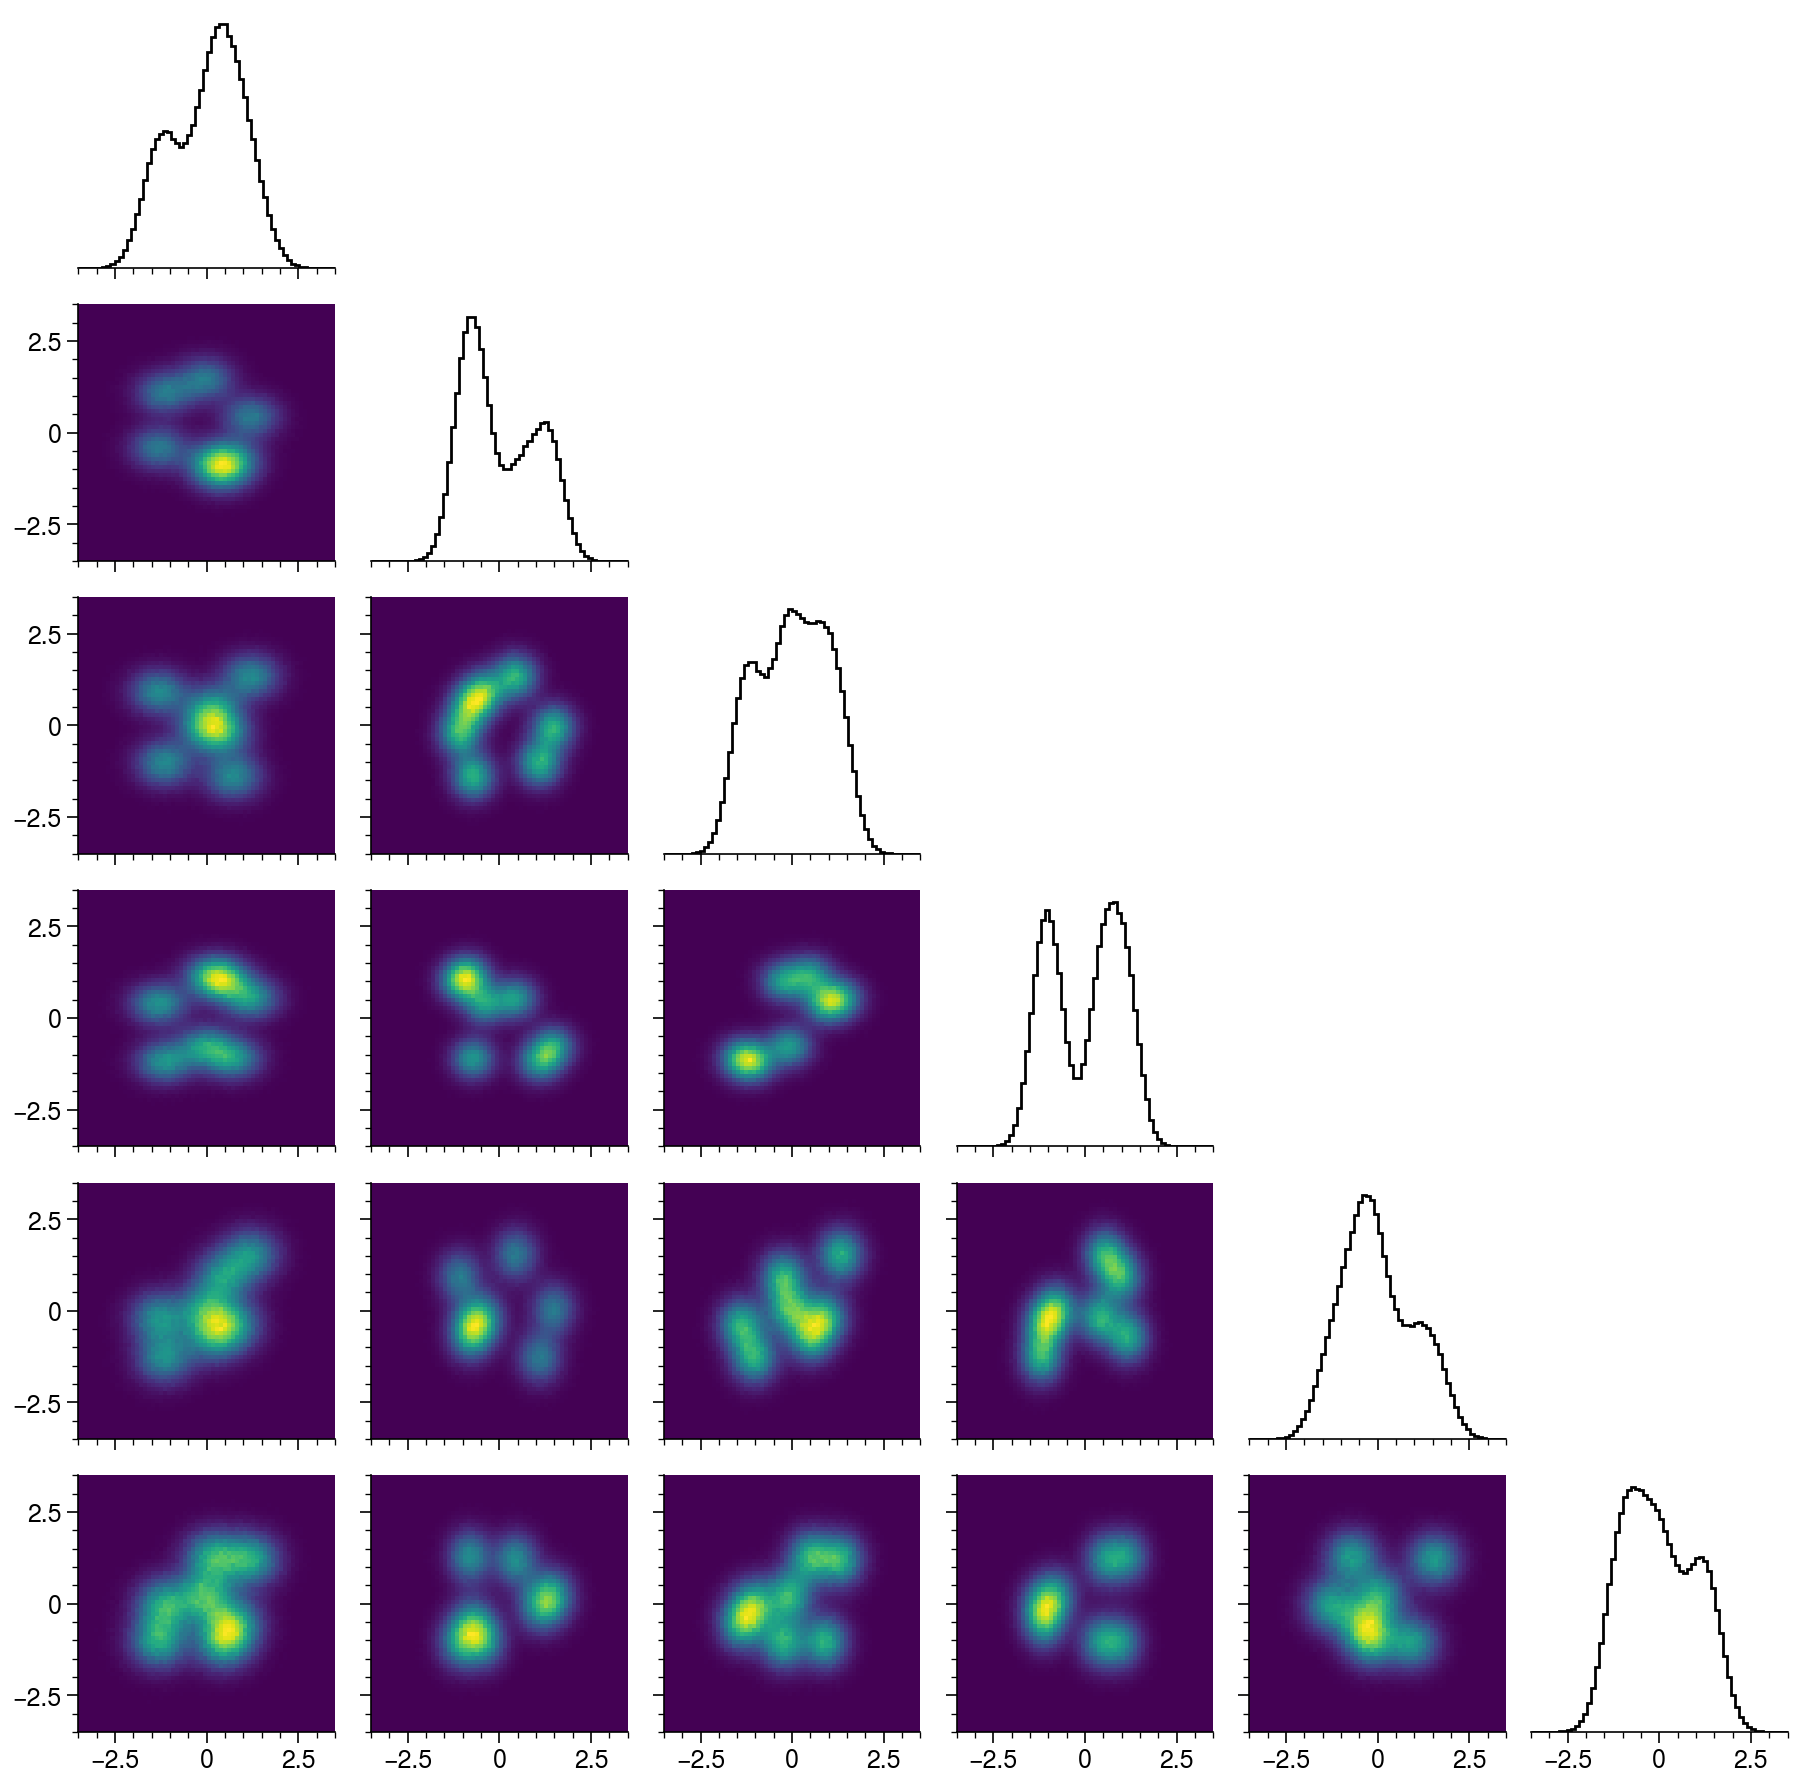

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
# Settings
nbins = 40
nmeas = ndim
kde = False
kde_bandwidth_frac = 1.0

## Measure 1D marginals
rng = np.random.default_rng(seed)
axis_meas = 0
n_meas = ndim

# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    j = axis_meas
    matrix = np.identity(ndim)
    matrix[i, i] = matrix[j, j] = 0.0
    matrix[i, j] = matrix[j, i] = 1.0
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth_frac=kde_bandwidth_frac
    )
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [7]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [8]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=True,
)

## Training

In [9]:
plot_nsamp = 1_000_000
plot_nbins = 64

In [10]:
plot_model = ment.train.Plotter(
    n_samples=plot_nsamp,
    plot_proj=[
        PlotProj1D(log=False),
        PlotProj1D(log=True),
    ],
    plot_dist=[
        PlotDistCorner(
            fig_kws=dict(figwidth=(ndim * 1.25), diag_shrink=0.80),
            limits=(ndim * [(-xmax, xmax)]),
            bins=plot_nbins,
        ),
    ],
)

eval_model = ment.train.Evaluator(n_samples=plot_nsamp)

non numeric history values being saved


  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▋                                                                                                                                               | 354/14031 [00:00<00:03, 3538.69it/s]

  5%|███████▍                                                                                                                                           | 713/14031 [00:00<00:03, 3566.77it/s]

  8%|███████████▏                                                                                                                                      | 1076/14031 [00:00<00:03, 3593.68it/s]

 10%|███████████████                                                                                                                                   | 1443/14031 [00:00<00:03, 3622.40it/s]

 13%|██████████████████▊                                                                                                                               | 1811/14031 [00:00<00:03, 3639.78it/s]

 16%|██████████████████████▋                                                                                                                           | 2178/14031 [00:00<00:03, 3649.54it/s]

 18%|██████████████████████████▌                                                                                                                       | 2547/14031 [00:00<00:03, 3661.97it/s]

 21%|██████████████████████████████▎                                                                                                                   | 2915/14031 [00:00<00:03, 3666.85it/s]

 23%|██████████████████████████████████▏                                                                                                               | 3283/14031 [00:00<00:02, 3667.96it/s]

 26%|██████████████████████████████████████                                                                                                            | 3652/14031 [00:01<00:02, 3674.15it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 4020/14031 [00:01<00:02, 3674.02it/s]

 31%|█████████████████████████████████████████████▋                                                                                                    | 4390/14031 [00:01<00:02, 3680.95it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 4761/14031 [00:01<00:02, 3688.62it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 5132/14031 [00:01<00:02, 3693.90it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 5502/14031 [00:01<00:02, 3687.97it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 5872/14031 [00:01<00:02, 3690.52it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                 | 6242/14031 [00:01<00:02, 3689.38it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 6614/14031 [00:01<00:02, 3696.54it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 6984/14031 [00:01<00:01, 3690.73it/s]

 52%|████████████████████████████████████████████████████████████████████████████▌                                                                     | 7354/14031 [00:02<00:01, 3673.96it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 7722/14031 [00:02<00:01, 3611.20it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 8084/14031 [00:02<00:01, 3604.32it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 8452/14031 [00:02<00:01, 3624.59it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 8815/14031 [00:02<00:01, 3608.33it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 9181/14031 [00:02<00:01, 3622.32it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 9549/14031 [00:02<00:01, 3636.70it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 9919/14031 [00:02<00:01, 3653.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 10290/14031 [00:02<00:01, 3669.63it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 10661/14031 [00:02<00:00, 3680.50it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 11030/14031 [00:03<00:00, 3673.74it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 11398/14031 [00:03<00:00, 3668.75it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 11766/14031 [00:03<00:00, 3669.96it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 12134/14031 [00:03<00:00, 3670.01it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 12503/14031 [00:03<00:00, 3674.18it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 12871/14031 [00:03<00:00, 3674.27it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 13239/14031 [00:03<00:00, 3641.66it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 13604/14031 [00:03<00:00, 3631.03it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 13968/14031 [00:03<00:00, 3629.17it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3654.14it/s]

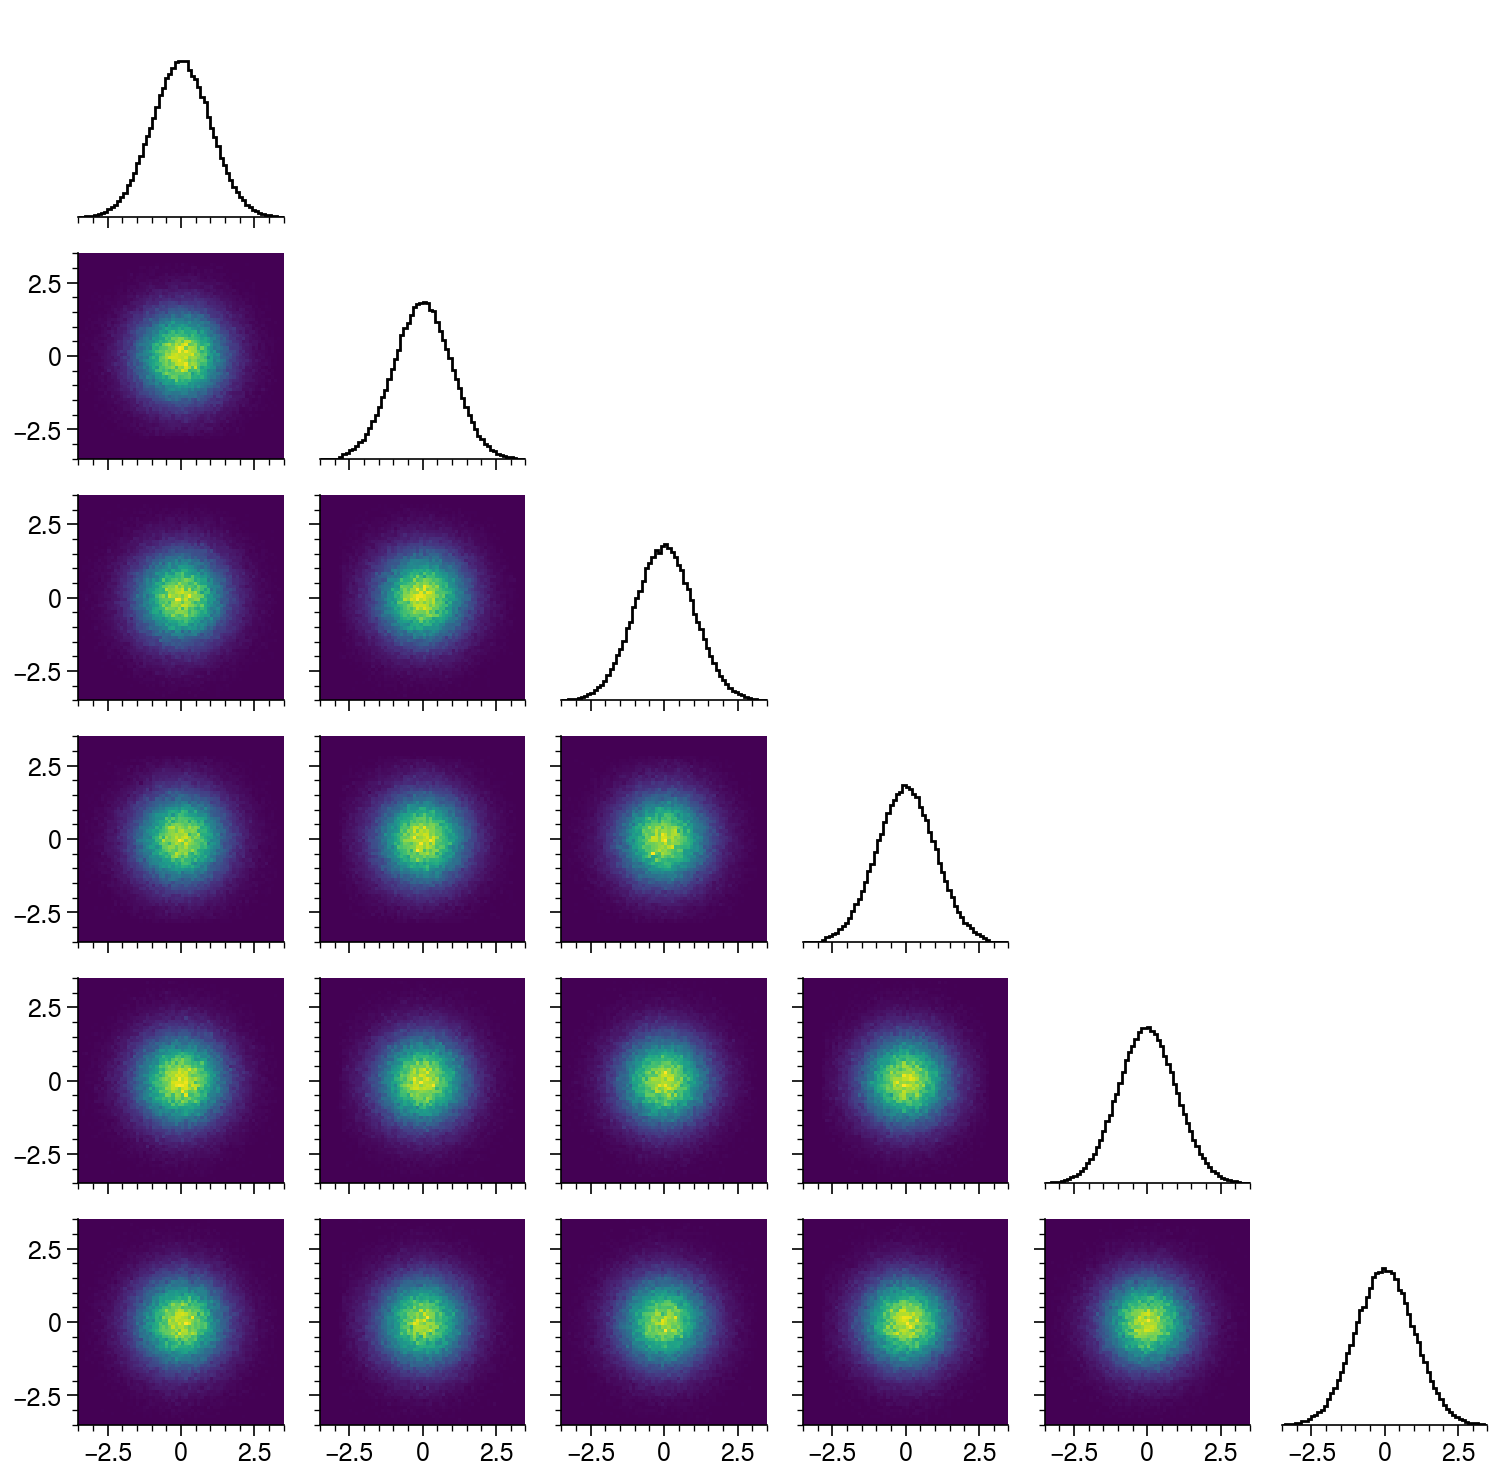

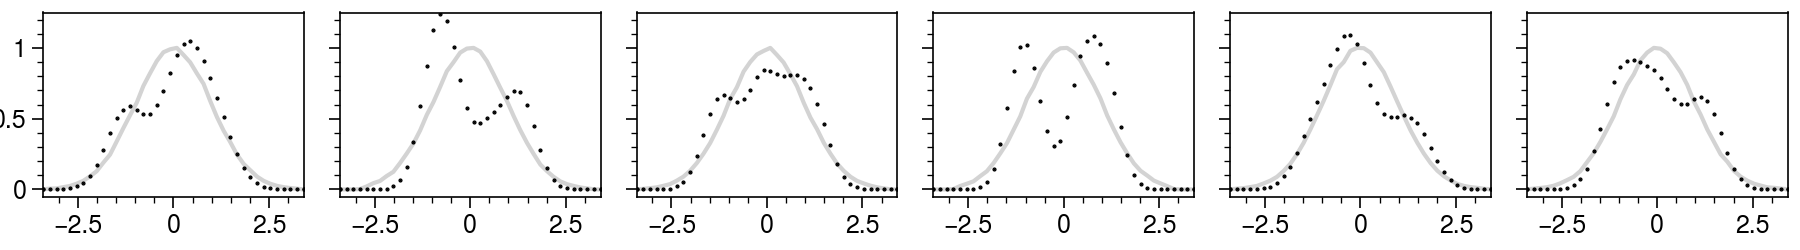

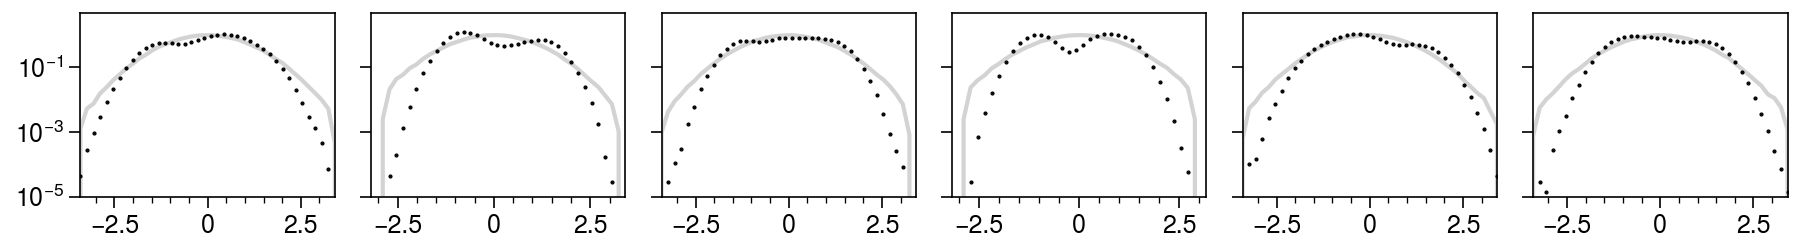

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▊                                                                                                                                               | 364/14031 [00:00<00:03, 3632.49it/s]

  5%|███████▋                                                                                                                                           | 733/14031 [00:00<00:03, 3665.10it/s]

  8%|███████████▍                                                                                                                                      | 1100/14031 [00:00<00:03, 3656.81it/s]

 10%|███████████████▎                                                                                                                                  | 1466/14031 [00:00<00:03, 3653.43it/s]

 13%|███████████████████                                                                                                                               | 1834/14031 [00:00<00:03, 3661.56it/s]

 16%|██████████████████████▉                                                                                                                           | 2204/14031 [00:00<00:03, 3673.67it/s]

 18%|██████████████████████████▊                                                                                                                       | 2575/14031 [00:00<00:03, 3682.69it/s]

 21%|██████████████████████████████▋                                                                                                                   | 2944/14031 [00:00<00:03, 3643.30it/s]

 24%|██████████████████████████████████▍                                                                                                               | 3309/14031 [00:00<00:02, 3627.47it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 3672/14031 [00:01<00:02, 3626.51it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 4036/14031 [00:01<00:02, 3628.01it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 4403/14031 [00:01<00:02, 3640.36it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 4768/14031 [00:01<00:02, 3630.13it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 5132/14031 [00:01<00:02, 3505.54it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 5491/14031 [00:01<00:02, 3529.32it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 5855/14031 [00:01<00:02, 3559.73it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                 | 6219/14031 [00:01<00:02, 3580.81it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 6583/14031 [00:01<00:02, 3597.72it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                         | 6953/14031 [00:01<00:01, 3625.67it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 7325/14031 [00:02<00:01, 3652.91it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 7697/14031 [00:02<00:01, 3670.20it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 8066/14031 [00:02<00:01, 3675.29it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 8434/14031 [00:02<00:01, 3666.72it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 8804/14031 [00:02<00:01, 3676.45it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 9177/14031 [00:02<00:01, 3691.48it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 9547/14031 [00:02<00:01, 3690.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 9917/14031 [00:02<00:01, 3662.71it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 10284/14031 [00:02<00:01, 3650.60it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 10650/14031 [00:02<00:00, 3633.24it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 11017/14031 [00:03<00:00, 3641.26it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 11387/14031 [00:03<00:00, 3658.23it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 11760/14031 [00:03<00:00, 3677.94it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 12131/14031 [00:03<00:00, 3685.19it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 12500/14031 [00:03<00:00, 3667.34it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 12869/14031 [00:03<00:00, 3673.30it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 13241/14031 [00:03<00:00, 3685.81it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 13610/14031 [00:03<00:00, 3674.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 13980/14031 [00:03<00:00, 3680.71it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3646.86it/s]

{'mean_abs_error': np.float64(0.04397816315112685)}
epoch = 1
transform=0
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▎                                                                                                                                              | 353/12015 [00:00<00:03, 3522.57it/s]

  6%|████████▊                                                                                                                                          | 717/12015 [00:00<00:03, 3590.51it/s]

  9%|█████████████▏                                                                                                                                    | 1086/12015 [00:00<00:03, 3634.30it/s]

 12%|█████████████████▌                                                                                                                                | 1450/12015 [00:00<00:02, 3601.29it/s]

 15%|██████████████████████                                                                                                                            | 1811/12015 [00:00<00:02, 3575.80it/s]

 18%|██████████████████████████▎                                                                                                                       | 2169/12015 [00:00<00:02, 3564.58it/s]

 21%|██████████████████████████████▋                                                                                                                   | 2526/12015 [00:00<00:02, 3424.94it/s]

 24%|███████████████████████████████████                                                                                                               | 2890/12015 [00:00<00:02, 3489.73it/s]

 27%|███████████████████████████████████████▍                                                                                                          | 3246/12015 [00:00<00:02, 3509.32it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 3605/12015 [00:01<00:02, 3531.21it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 3970/12015 [00:01<00:02, 3565.66it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 4341/12015 [00:01<00:02, 3607.31it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 4710/12015 [00:01<00:02, 3631.39it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                    | 5075/12015 [00:01<00:01, 3635.58it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5440/12015 [00:01<00:01, 3639.11it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5805/12015 [00:01<00:01, 3638.91it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 6174/12015 [00:01<00:01, 3653.19it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 6540/12015 [00:01<00:01, 3637.94it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 6904/12015 [00:01<00:01, 3630.40it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7268/12015 [00:02<00:01, 3629.01it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 7631/12015 [00:02<00:01, 3624.62it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 7994/12015 [00:02<00:01, 3619.12it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 8356/12015 [00:02<00:01, 3602.26it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 8717/12015 [00:02<00:00, 3591.58it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 9077/12015 [00:02<00:00, 3587.77it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 9444/12015 [00:02<00:00, 3610.58it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 9809/12015 [00:02<00:00, 3620.85it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 10176/12015 [00:02<00:00, 3633.33it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 10544/12015 [00:02<00:00, 3646.15it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 10914/12015 [00:03<00:00, 3661.25it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11281/12015 [00:03<00:00, 3493.51it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11641/12015 [00:03<00:00, 3523.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 12009/12015 [00:03<00:00, 3566.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3589.53it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 361/12015 [00:00<00:03, 3608.73it/s]

  6%|████████▉                                                                                                                                          | 732/12015 [00:00<00:03, 3667.69it/s]

  9%|█████████████▎                                                                                                                                    | 1099/12015 [00:00<00:02, 3665.98it/s]

 12%|█████████████████▊                                                                                                                                | 1467/12015 [00:00<00:02, 3668.51it/s]

 15%|██████████████████████▎                                                                                                                           | 1834/12015 [00:00<00:02, 3663.74it/s]

 18%|██████████████████████████▋                                                                                                                       | 2201/12015 [00:00<00:02, 3654.41it/s]

 21%|███████████████████████████████▏                                                                                                                  | 2571/12015 [00:00<00:02, 3668.13it/s]

 24%|███████████████████████████████████▊                                                                                                              | 2943/12015 [00:00<00:02, 3684.53it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 3312/12015 [00:00<00:02, 3671.82it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3680/12015 [00:01<00:02, 3665.09it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4047/12015 [00:01<00:02, 3657.48it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 4413/12015 [00:01<00:02, 3655.42it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 4781/12015 [00:01<00:01, 3660.10it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                   | 5150/12015 [00:01<00:01, 3668.54it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 5520/12015 [00:01<00:01, 3676.74it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 5888/12015 [00:01<00:01, 3673.34it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 6256/12015 [00:01<00:01, 3672.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6624/12015 [00:01<00:01, 3672.99it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 6997/12015 [00:01<00:01, 3688.03it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 7366/12015 [00:02<00:01, 3668.03it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7733/12015 [00:02<00:01, 3633.94it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8099/12015 [00:02<00:01, 3640.01it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8464/12015 [00:02<00:00, 3619.36it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 8830/12015 [00:02<00:00, 3629.91it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 9194/12015 [00:02<00:00, 3619.01it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 9556/12015 [00:02<00:00, 3543.78it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 9912/12015 [00:02<00:00, 3548.15it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 10279/12015 [00:02<00:00, 3582.13it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 10651/12015 [00:02<00:00, 3622.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 11018/12015 [00:03<00:00, 3634.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 11386/12015 [00:03<00:00, 3647.38it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 11751/12015 [00:03<00:00, 3641.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3645.65it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 364/12015 [00:00<00:03, 3637.38it/s]

  6%|████████▉                                                                                                                                          | 728/12015 [00:00<00:03, 3634.52it/s]

  9%|█████████████▎                                                                                                                                    | 1099/12015 [00:00<00:02, 3665.03it/s]

 12%|█████████████████▊                                                                                                                                | 1466/12015 [00:00<00:02, 3666.52it/s]

 15%|██████████████████████▎                                                                                                                           | 1833/12015 [00:00<00:02, 3658.68it/s]

 18%|██████████████████████████▋                                                                                                                       | 2199/12015 [00:00<00:02, 3645.12it/s]

 21%|███████████████████████████████▏                                                                                                                  | 2565/12015 [00:00<00:02, 3647.02it/s]

 24%|███████████████████████████████████▋                                                                                                              | 2937/12015 [00:00<00:02, 3670.15it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 3305/12015 [00:00<00:02, 3657.76it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3676/12015 [00:01<00:02, 3672.10it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4044/12015 [00:01<00:02, 3663.31it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 4411/12015 [00:01<00:02, 3543.07it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 4774/12015 [00:01<00:02, 3566.19it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 5135/12015 [00:01<00:01, 3577.94it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 5499/12015 [00:01<00:01, 3596.10it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 5862/12015 [00:01<00:01, 3605.49it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 6226/12015 [00:01<00:01, 3614.94it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 6588/12015 [00:01<00:01, 3596.29it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 6948/12015 [00:01<00:01, 3597.28it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 7308/12015 [00:02<00:01, 3469.45it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7668/12015 [00:02<00:01, 3504.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 8029/12015 [00:02<00:01, 3535.64it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 8393/12015 [00:02<00:01, 3564.23it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8759/12015 [00:02<00:00, 3591.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9131/12015 [00:02<00:00, 3627.39it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 9502/12015 [00:02<00:00, 3651.94it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 9872/12015 [00:02<00:00, 3664.70it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10244/12015 [00:02<00:00, 3679.73it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 10613/12015 [00:02<00:00, 3676.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 10987/12015 [00:03<00:00, 3694.98it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 11358/12015 [00:03<00:00, 3699.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11729/12015 [00:03<00:00, 3700.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3629.66it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 367/12015 [00:00<00:03, 3660.47it/s]

  6%|████████▉                                                                                                                                          | 734/12015 [00:00<00:03, 3664.37it/s]

  9%|█████████████▍                                                                                                                                    | 1101/12015 [00:00<00:02, 3645.91it/s]

 12%|█████████████████▊                                                                                                                                | 1467/12015 [00:00<00:02, 3649.06it/s]

 15%|██████████████████████▎                                                                                                                           | 1832/12015 [00:00<00:02, 3639.06it/s]

 18%|██████████████████████████▋                                                                                                                       | 2199/12015 [00:00<00:02, 3648.61it/s]

 21%|███████████████████████████████▏                                                                                                                  | 2565/12015 [00:00<00:02, 3650.31it/s]

 24%|███████████████████████████████████▋                                                                                                              | 2935/12015 [00:00<00:02, 3665.61it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 3307/12015 [00:00<00:02, 3681.80it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3676/12015 [00:01<00:02, 3681.14it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4046/12015 [00:01<00:02, 3685.04it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4416/12015 [00:01<00:02, 3688.62it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 4785/12015 [00:01<00:01, 3659.11it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                   | 5151/12015 [00:01<00:01, 3634.74it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 5516/12015 [00:01<00:01, 3638.34it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 5886/12015 [00:01<00:01, 3654.35it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 6252/12015 [00:01<00:01, 3548.50it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6617/12015 [00:01<00:01, 3577.91it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6989/12015 [00:01<00:01, 3618.80it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7362/12015 [00:02<00:01, 3649.80it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7735/12015 [00:02<00:01, 3673.23it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 8105/12015 [00:02<00:01, 3678.91it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 8474/12015 [00:02<00:00, 3676.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 8846/12015 [00:02<00:00, 3688.26it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 9215/12015 [00:02<00:00, 3681.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 9584/12015 [00:02<00:00, 3655.14it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 9950/12015 [00:02<00:00, 3632.49it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 10317/12015 [00:02<00:00, 3642.08it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 10682/12015 [00:02<00:00, 3635.38it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 11049/12015 [00:03<00:00, 3644.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 11414/12015 [00:03<00:00, 3641.69it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 11779/12015 [00:03<00:00, 3620.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3645.53it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▎                                                                                                                                              | 357/12015 [00:00<00:03, 3568.04it/s]

  6%|████████▊                                                                                                                                          | 725/12015 [00:00<00:03, 3629.22it/s]

  9%|█████████████▏                                                                                                                                    | 1088/12015 [00:00<00:03, 3450.56it/s]

 12%|█████████████████▋                                                                                                                                | 1451/12015 [00:00<00:03, 3516.13it/s]

 15%|██████████████████████▏                                                                                                                           | 1824/12015 [00:00<00:02, 3588.98it/s]

 18%|██████████████████████████▌                                                                                                                       | 2188/12015 [00:00<00:02, 3605.02it/s]

 21%|██████████████████████████████▉                                                                                                                   | 2549/12015 [00:00<00:02, 3591.34it/s]

 24%|███████████████████████████████████▎                                                                                                              | 2909/12015 [00:00<00:02, 3572.78it/s]

 27%|███████████████████████████████████████▋                                                                                                          | 3267/12015 [00:00<00:02, 3567.70it/s]

 30%|████████████████████████████████████████████                                                                                                      | 3626/12015 [00:01<00:02, 3571.77it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 3984/12015 [00:01<00:02, 3443.56it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 4341/12015 [00:01<00:02, 3480.41it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 4701/12015 [00:01<00:02, 3513.51it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 5060/12015 [00:01<00:01, 3534.83it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 5420/12015 [00:01<00:01, 3552.38it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 5776/12015 [00:01<00:01, 3545.26it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 6131/12015 [00:01<00:01, 3530.60it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 6485/12015 [00:01<00:01, 3436.46it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 6847/12015 [00:01<00:01, 3489.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 7205/12015 [00:02<00:01, 3514.62it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7565/12015 [00:02<00:01, 3538.07it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 7936/12015 [00:02<00:01, 3587.13it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8300/12015 [00:02<00:01, 3601.12it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 8668/12015 [00:02<00:00, 3622.64it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 9031/12015 [00:02<00:00, 3612.62it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 9393/12015 [00:02<00:00, 3601.74it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 9754/12015 [00:02<00:00, 3601.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 10115/12015 [00:02<00:00, 3594.29it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 10475/12015 [00:02<00:00, 3477.68it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 10840/12015 [00:03<00:00, 3527.27it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 11208/12015 [00:03<00:00, 3571.67it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 11580/12015 [00:03<00:00, 3614.50it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 11947/12015 [00:03<00:00, 3628.97it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3558.38it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 367/12015 [00:00<00:03, 3665.31it/s]

  6%|████████▉                                                                                                                                          | 734/12015 [00:00<00:03, 3625.35it/s]

  9%|█████████████▎                                                                                                                                    | 1097/12015 [00:00<00:03, 3587.48it/s]

 12%|█████████████████▋                                                                                                                                | 1460/12015 [00:00<00:02, 3602.03it/s]

 15%|██████████████████████▏                                                                                                                           | 1821/12015 [00:00<00:02, 3593.17it/s]

 18%|██████████████████████████▌                                                                                                                       | 2181/12015 [00:00<00:02, 3595.30it/s]

 21%|██████████████████████████████▉                                                                                                                   | 2541/12015 [00:00<00:02, 3478.53it/s]

 24%|███████████████████████████████████▏                                                                                                              | 2897/12015 [00:00<00:02, 3503.31it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 3254/12015 [00:00<00:02, 3521.39it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 3611/12015 [00:01<00:02, 3534.03it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 3971/12015 [00:01<00:02, 3552.69it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 4332/12015 [00:01<00:02, 3569.17it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 4690/12015 [00:01<00:02, 3562.74it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 5047/12015 [00:01<00:02, 3452.14it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 5405/12015 [00:01<00:01, 3487.90it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                            | 5764/12015 [00:01<00:01, 3517.28it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                       | 6122/12015 [00:01<00:01, 3533.74it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▊                                                                   | 6481/12015 [00:01<00:01, 3549.76it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████                                                               | 6837/12015 [00:01<00:01, 3542.80it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 7197/12015 [00:02<00:01, 3557.93it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 7567/12015 [00:02<00:01, 3599.37it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7928/12015 [00:02<00:01, 3498.67it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 8292/12015 [00:02<00:01, 3538.50it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 8661/12015 [00:02<00:00, 3580.39it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 9034/12015 [00:02<00:00, 3623.13it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 9408/12015 [00:02<00:00, 3655.26it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 9778/12015 [00:02<00:00, 3668.35it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 10148/12015 [00:02<00:00, 3676.50it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 10516/12015 [00:02<00:00, 3675.71it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 10887/12015 [00:03<00:00, 3685.38it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 11258/12015 [00:03<00:00, 3690.70it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11628/12015 [00:03<00:00, 3690.39it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 11998/12015 [00:03<00:00, 3681.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3588.55it/s]

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▊                                                                                                                                               | 365/14031 [00:00<00:03, 3648.06it/s]

  5%|███████▋                                                                                                                                           | 730/14031 [00:00<00:03, 3637.65it/s]

  8%|███████████▍                                                                                                                                      | 1094/14031 [00:00<00:03, 3599.12it/s]

 10%|███████████████▏                                                                                                                                  | 1454/14031 [00:00<00:03, 3561.98it/s]

 13%|██████████████████▊                                                                                                                               | 1811/14031 [00:00<00:03, 3564.72it/s]

 15%|██████████████████████▌                                                                                                                           | 2170/14031 [00:00<00:03, 3570.70it/s]

 18%|██████████████████████████▎                                                                                                                       | 2528/14031 [00:00<00:03, 3467.64it/s]

 21%|██████████████████████████████                                                                                                                    | 2890/14031 [00:00<00:03, 3513.18it/s]

 23%|█████████████████████████████████▉                                                                                                                | 3257/14031 [00:00<00:03, 3561.10it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 3629/14031 [00:01<00:02, 3607.91it/s]

 28%|█████████████████████████████████████████▌                                                                                                        | 3991/14031 [00:01<00:02, 3604.85it/s]

 31%|█████████████████████████████████████████████▎                                                                                                    | 4355/14031 [00:01<00:02, 3613.90it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 4717/14031 [00:01<00:02, 3605.37it/s]

 36%|████████████████████████████████████████████████████▊                                                                                             | 5081/14031 [00:01<00:02, 3615.03it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                         | 5443/14031 [00:01<00:02, 3609.15it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 5808/14031 [00:01<00:02, 3620.71it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                 | 6179/14031 [00:01<00:02, 3645.60it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 6551/14031 [00:01<00:02, 3666.34it/s]

 49%|███████████████████████████████████████████████████████████████████████▉                                                                          | 6918/14031 [00:01<00:01, 3666.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 7285/14031 [00:02<00:01, 3666.97it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 7652/14031 [00:02<00:01, 3660.72it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▍                                                              | 8021/14031 [00:02<00:01, 3667.65it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 8390/14031 [00:02<00:01, 3672.52it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 8758/14031 [00:02<00:01, 3663.20it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 9126/14031 [00:02<00:01, 3665.69it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 9493/14031 [00:02<00:01, 3661.11it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 9860/14031 [00:02<00:01, 3660.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 10227/14031 [00:02<00:01, 3660.80it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 10594/14031 [00:02<00:00, 3659.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 10963/14031 [00:03<00:00, 3667.21it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 11330/14031 [00:03<00:00, 3643.62it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 11695/14031 [00:03<00:00, 3612.66it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 12057/14031 [00:03<00:00, 3483.62it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 12414/14031 [00:03<00:00, 3506.22it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 12776/14031 [00:03<00:00, 3538.64it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 13146/14031 [00:03<00:00, 3583.81it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 13517/14031 [00:03<00:00, 3619.61it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 13885/14031 [00:03<00:00, 3635.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3614.63it/s]

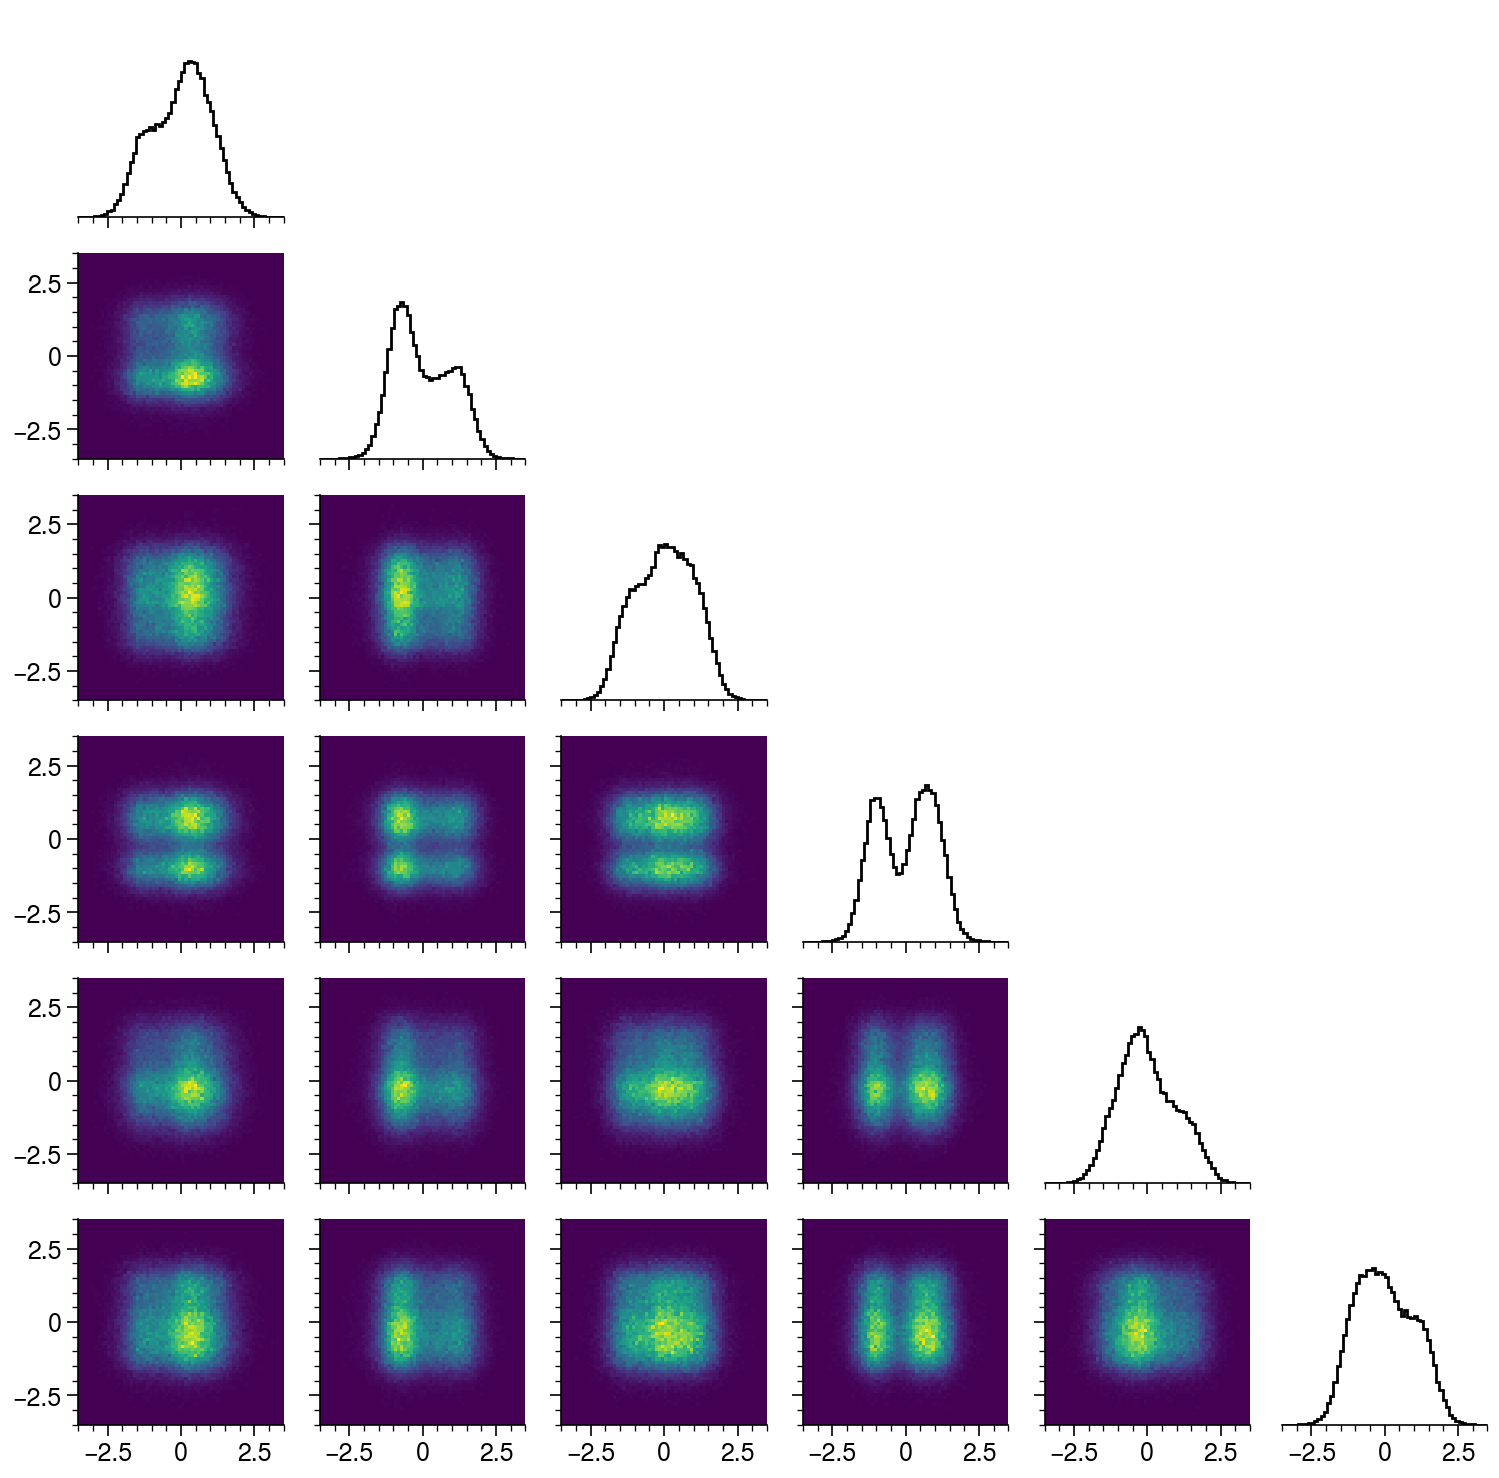

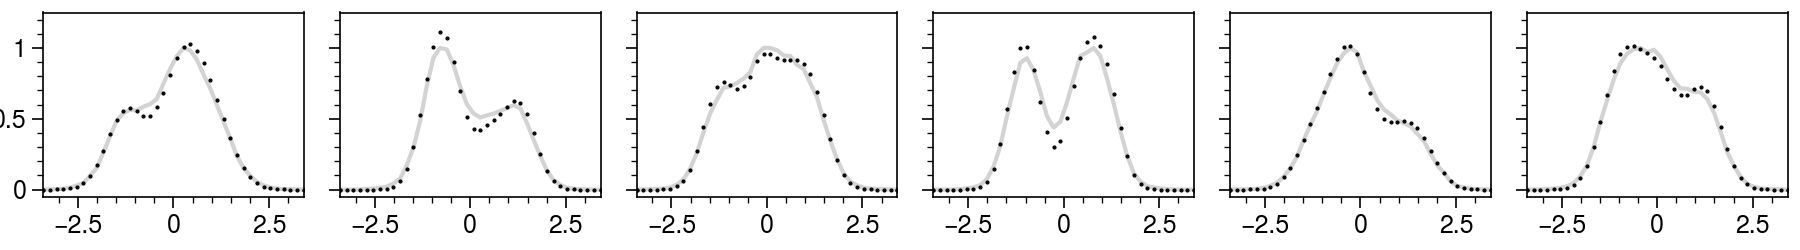

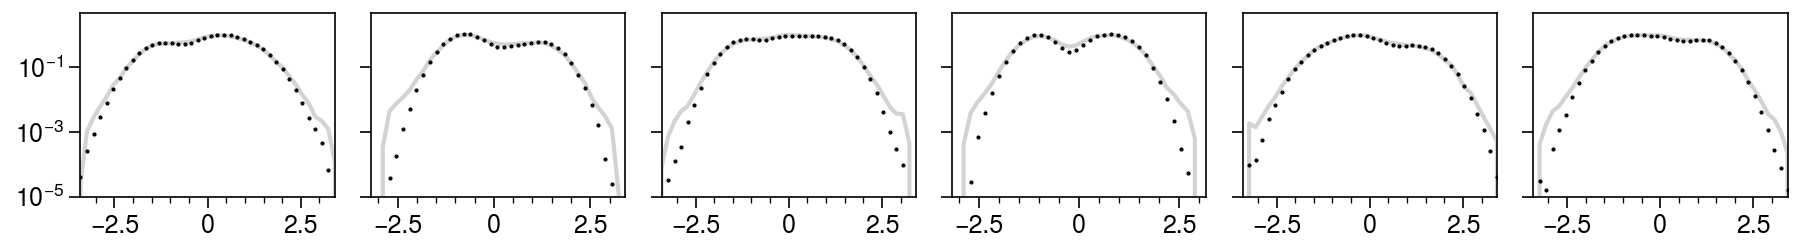

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▊                                                                                                                                               | 363/14031 [00:00<00:03, 3624.32it/s]

  5%|███████▌                                                                                                                                           | 727/14031 [00:00<00:03, 3630.19it/s]

  8%|███████████▎                                                                                                                                      | 1091/14031 [00:00<00:03, 3583.01it/s]

 10%|███████████████                                                                                                                                   | 1450/14031 [00:00<00:03, 3374.37it/s]

 13%|██████████████████▉                                                                                                                               | 1816/14031 [00:00<00:03, 3472.11it/s]

 16%|██████████████████████▋                                                                                                                           | 2184/14031 [00:00<00:03, 3539.99it/s]

 18%|██████████████████████████▌                                                                                                                       | 2555/14031 [00:00<00:03, 3593.18it/s]

 21%|██████████████████████████████▍                                                                                                                   | 2926/14031 [00:00<00:03, 3628.26it/s]

 23%|██████████████████████████████████▎                                                                                                               | 3294/14031 [00:00<00:02, 3641.52it/s]

 26%|██████████████████████████████████████                                                                                                            | 3661/14031 [00:01<00:02, 3649.65it/s]

 29%|█████████████████████████████████████████▉                                                                                                        | 4030/14031 [00:01<00:02, 3659.33it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 4399/14031 [00:01<00:02, 3667.83it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 4766/14031 [00:01<00:02, 3666.05it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 5133/14031 [00:01<00:02, 3657.11it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 5501/14031 [00:01<00:02, 3663.47it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                     | 5871/14031 [00:01<00:02, 3673.03it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                 | 6239/14031 [00:01<00:02, 3661.23it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                             | 6606/14031 [00:01<00:02, 3660.59it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 6974/14031 [00:01<00:01, 3664.58it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 7342/14031 [00:02<00:01, 3668.80it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7712/14031 [00:02<00:01, 3676.40it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 8082/14031 [00:02<00:01, 3680.81it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 8451/14031 [00:02<00:01, 3663.92it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 8818/14031 [00:02<00:01, 3659.24it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 9187/14031 [00:02<00:01, 3666.46it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 9558/14031 [00:02<00:01, 3678.63it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 9930/14031 [00:02<00:01, 3690.00it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 10302/14031 [00:02<00:01, 3697.50it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 10672/14031 [00:02<00:00, 3690.42it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 11044/14031 [00:03<00:00, 3698.17it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 11417/14031 [00:03<00:00, 3704.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 11790/14031 [00:03<00:00, 3709.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 12161/14031 [00:03<00:00, 3659.03it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 12528/14031 [00:03<00:00, 3639.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 12897/14031 [00:03<00:00, 3652.42it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 13268/14031 [00:03<00:00, 3668.15it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 13635/14031 [00:03<00:00, 3645.83it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 14001/14031 [00:03<00:00, 3648.23it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3647.96it/s]

{'mean_abs_error': np.float64(0.010181797864649582)}
epoch = 2
transform=0
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 358/12015 [00:00<00:03, 3577.82it/s]

  6%|████████▊                                                                                                                                          | 725/12015 [00:00<00:03, 3626.44it/s]

  9%|█████████████▎                                                                                                                                    | 1092/12015 [00:00<00:02, 3646.13it/s]

 12%|█████████████████▋                                                                                                                                | 1459/12015 [00:00<00:02, 3654.97it/s]

 15%|██████████████████████▏                                                                                                                           | 1825/12015 [00:00<00:02, 3649.98it/s]

 18%|██████████████████████████▋                                                                                                                       | 2194/12015 [00:00<00:02, 3662.43it/s]

 21%|███████████████████████████████▏                                                                                                                  | 2564/12015 [00:00<00:02, 3673.84it/s]

 24%|███████████████████████████████████▋                                                                                                              | 2932/12015 [00:00<00:02, 3671.01it/s]

 27%|████████████████████████████████████████                                                                                                          | 3300/12015 [00:00<00:02, 3630.16it/s]

 30%|████████████████████████████████████████████▌                                                                                                     | 3664/12015 [00:01<00:02, 3608.50it/s]

 33%|████████████████████████████████████████████████▉                                                                                                 | 4025/12015 [00:01<00:02, 3591.79it/s]

 36%|█████████████████████████████████████████████████████▎                                                                                            | 4385/12015 [00:01<00:02, 3564.93it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 4742/12015 [00:01<00:02, 3441.14it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 5099/12015 [00:01<00:01, 3476.22it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 5460/12015 [00:01<00:01, 3514.22it/s]

 48%|██████████████████████████████████████████████████████████████████████▊                                                                           | 5823/12015 [00:01<00:01, 3547.58it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 6186/12015 [00:01<00:01, 3571.58it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 6554/12015 [00:01<00:01, 3602.77it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 6922/12015 [00:01<00:01, 3625.58it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 7292/12015 [00:02<00:01, 3645.78it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 7663/12015 [00:02<00:01, 3662.49it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 8033/12015 [00:02<00:01, 3672.69it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 8405/12015 [00:02<00:00, 3684.99it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 8774/12015 [00:02<00:00, 3683.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 9144/12015 [00:02<00:00, 3686.61it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 9516/12015 [00:02<00:00, 3696.30it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 9886/12015 [00:02<00:00, 3697.37it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10256/12015 [00:02<00:00, 3672.01it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10624/12015 [00:02<00:00, 3665.10it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 10992/12015 [00:03<00:00, 3666.80it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 11361/12015 [00:03<00:00, 3673.05it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11729/12015 [00:03<00:00, 3673.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3632.94it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 366/12015 [00:00<00:03, 3651.71it/s]

  6%|████████▉                                                                                                                                          | 732/12015 [00:00<00:03, 3653.10it/s]

  9%|█████████████▎                                                                                                                                    | 1100/12015 [00:00<00:02, 3664.65it/s]

 12%|█████████████████▊                                                                                                                                | 1470/12015 [00:00<00:02, 3677.20it/s]

 15%|██████████████████████▎                                                                                                                           | 1840/12015 [00:00<00:02, 3682.18it/s]

 18%|██████████████████████████▊                                                                                                                       | 2209/12015 [00:00<00:02, 3655.42it/s]

 21%|███████████████████████████████▎                                                                                                                  | 2576/12015 [00:00<00:02, 3659.25it/s]

 25%|███████████████████████████████████▊                                                                                                              | 2945/12015 [00:00<00:02, 3668.41it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 3316/12015 [00:00<00:02, 3678.80it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 3685/12015 [00:01<00:02, 3679.61it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4053/12015 [00:01<00:02, 3670.91it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4421/12015 [00:01<00:02, 3659.11it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 4787/12015 [00:01<00:01, 3658.27it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                   | 5153/12015 [00:01<00:01, 3653.32it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 5519/12015 [00:01<00:01, 3652.48it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 5885/12015 [00:01<00:01, 3650.35it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                      | 6251/12015 [00:01<00:01, 3650.89it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 6617/12015 [00:01<00:01, 3651.91it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 6983/12015 [00:01<00:01, 3647.66it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 7349/12015 [00:02<00:01, 3650.03it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 7719/12015 [00:02<00:01, 3662.48it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 8088/12015 [00:02<00:01, 3668.02it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8456/12015 [00:02<00:00, 3668.72it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8825/12015 [00:02<00:00, 3672.21it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 9193/12015 [00:02<00:00, 3670.28it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 9561/12015 [00:02<00:00, 3661.74it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9928/12015 [00:02<00:00, 3651.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 10297/12015 [00:02<00:00, 3661.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10668/12015 [00:02<00:00, 3674.94it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11037/12015 [00:03<00:00, 3678.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 11405/12015 [00:03<00:00, 3674.72it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 11773/12015 [00:03<00:00, 3666.99it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3663.24it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 367/12015 [00:00<00:03, 3667.47it/s]

  6%|████████▉                                                                                                                                          | 734/12015 [00:00<00:03, 3651.88it/s]

  9%|█████████████▍                                                                                                                                    | 1102/12015 [00:00<00:02, 3662.52it/s]

 12%|█████████████████▊                                                                                                                                | 1469/12015 [00:00<00:02, 3656.06it/s]

 15%|██████████████████████▎                                                                                                                           | 1835/12015 [00:00<00:02, 3643.11it/s]

 18%|██████████████████████████▊                                                                                                                       | 2203/12015 [00:00<00:02, 3653.12it/s]

 21%|███████████████████████████████▏                                                                                                                  | 2569/12015 [00:00<00:02, 3648.98it/s]

 24%|███████████████████████████████████▋                                                                                                              | 2934/12015 [00:00<00:02, 3646.61it/s]

 27%|████████████████████████████████████████                                                                                                          | 3301/12015 [00:00<00:02, 3651.92it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 3667/12015 [00:01<00:02, 3654.39it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 4034/12015 [00:01<00:02, 3658.98it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                            | 4402/12015 [00:01<00:02, 3663.37it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                        | 4771/12015 [00:01<00:01, 3670.94it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 5139/12015 [00:01<00:01, 3655.27it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                               | 5505/12015 [00:01<00:01, 3649.65it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 5870/12015 [00:01<00:01, 3526.69it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 6232/12015 [00:01<00:01, 3551.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 6596/12015 [00:01<00:01, 3577.38it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6961/12015 [00:01<00:01, 3596.34it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 7328/12015 [00:02<00:01, 3617.72it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7699/12015 [00:02<00:01, 3642.82it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8064/12015 [00:02<00:01, 3642.61it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8429/12015 [00:02<00:01, 3559.74it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 8793/12015 [00:02<00:00, 3580.79it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 9158/12015 [00:02<00:00, 3599.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 9528/12015 [00:02<00:00, 3626.69it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 9893/12015 [00:02<00:00, 3632.98it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 10259/12015 [00:02<00:00, 3639.16it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10625/12015 [00:02<00:00, 3643.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 10994/12015 [00:03<00:00, 3655.48it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 11363/12015 [00:03<00:00, 3663.32it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11731/12015 [00:03<00:00, 3666.52it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3634.50it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▌                                                                                                                                              | 368/12015 [00:00<00:03, 3670.31it/s]

  6%|█████████                                                                                                                                          | 736/12015 [00:00<00:03, 3675.14it/s]

  9%|█████████████▍                                                                                                                                    | 1104/12015 [00:00<00:02, 3663.38it/s]

 12%|█████████████████▉                                                                                                                                | 1474/12015 [00:00<00:02, 3677.51it/s]

 15%|██████████████████████▍                                                                                                                           | 1843/12015 [00:00<00:02, 3681.41it/s]

 18%|██████████████████████████▉                                                                                                                       | 2212/12015 [00:00<00:02, 3673.61it/s]

 21%|███████████████████████████████▎                                                                                                                  | 2580/12015 [00:00<00:02, 3669.04it/s]

 25%|███████████████████████████████████▊                                                                                                              | 2948/12015 [00:00<00:02, 3669.74it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 3315/12015 [00:00<00:02, 3668.09it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3682/12015 [00:01<00:02, 3661.99it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4051/12015 [00:01<00:02, 3668.30it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4418/12015 [00:01<00:02, 3668.58it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 4785/12015 [00:01<00:01, 3664.38it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                   | 5153/12015 [00:01<00:01, 3668.28it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 5524/12015 [00:01<00:01, 3680.67it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 5893/12015 [00:01<00:01, 3669.60it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 6260/12015 [00:01<00:01, 3657.52it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 6627/12015 [00:01<00:01, 3658.36it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▉                                                             | 6994/12015 [00:01<00:01, 3659.15it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7360/12015 [00:02<00:01, 3655.53it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7726/12015 [00:02<00:01, 3655.65it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 8092/12015 [00:02<00:01, 3653.26it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8459/12015 [00:02<00:00, 3657.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 8827/12015 [00:02<00:00, 3662.43it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 9195/12015 [00:02<00:00, 3666.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 9563/12015 [00:02<00:00, 3668.41it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 9930/12015 [00:02<00:00, 3665.81it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 10297/12015 [00:02<00:00, 3666.10it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 10665/12015 [00:02<00:00, 3668.53it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 11032/12015 [00:03<00:00, 3667.20it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11399/12015 [00:03<00:00, 3660.60it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 11767/12015 [00:03<00:00, 3664.11it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3665.44it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 366/12015 [00:00<00:03, 3651.68it/s]

  6%|█████████                                                                                                                                          | 737/12015 [00:00<00:03, 3682.47it/s]

  9%|█████████████▍                                                                                                                                    | 1106/12015 [00:00<00:02, 3677.18it/s]

 12%|█████████████████▉                                                                                                                                | 1474/12015 [00:00<00:02, 3670.10it/s]

 15%|██████████████████████▍                                                                                                                           | 1842/12015 [00:00<00:02, 3663.21it/s]

 18%|██████████████████████████▊                                                                                                                       | 2210/12015 [00:00<00:02, 3668.12it/s]

 21%|███████████████████████████████▎                                                                                                                  | 2581/12015 [00:00<00:02, 3678.62it/s]

 25%|███████████████████████████████████▊                                                                                                              | 2951/12015 [00:00<00:02, 3682.33it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 3320/12015 [00:00<00:02, 3673.54it/s]

 31%|████████████████████████████████████████████▊                                                                                                     | 3688/12015 [00:01<00:02, 3667.63it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 4055/12015 [00:01<00:02, 3662.84it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4422/12015 [00:01<00:02, 3659.97it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 4788/12015 [00:01<00:01, 3656.08it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 5154/12015 [00:01<00:01, 3655.37it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 5522/12015 [00:01<00:01, 3660.06it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                          | 5891/12015 [00:01<00:01, 3668.80it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 6259/12015 [00:01<00:01, 3669.54it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 6629/12015 [00:01<00:01, 3678.21it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 6997/12015 [00:01<00:01, 3668.48it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 7364/12015 [00:02<00:01, 3657.32it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 7730/12015 [00:02<00:01, 3647.05it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 8095/12015 [00:02<00:01, 3639.17it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 8459/12015 [00:02<00:00, 3607.27it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 8820/12015 [00:02<00:00, 3581.10it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 9179/12015 [00:02<00:00, 3534.99it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 9533/12015 [00:02<00:00, 3500.63it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9885/12015 [00:02<00:00, 3504.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 10237/12015 [00:02<00:00, 3507.83it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 10599/12015 [00:02<00:00, 3540.43it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 10965/12015 [00:03<00:00, 3574.84it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11329/12015 [00:03<00:00, 3593.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11697/12015 [00:03<00:00, 3616.70it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3628.92it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▎                                                                                                                                              | 355/12015 [00:00<00:03, 3542.49it/s]

  6%|████████▋                                                                                                                                          | 710/12015 [00:00<00:03, 3529.58it/s]

  9%|█████████████                                                                                                                                     | 1070/12015 [00:00<00:03, 3561.07it/s]

 12%|█████████████████▍                                                                                                                                | 1435/12015 [00:00<00:02, 3594.42it/s]

 15%|█████████████████████▊                                                                                                                            | 1795/12015 [00:00<00:02, 3595.22it/s]

 18%|██████████████████████████▏                                                                                                                       | 2155/12015 [00:00<00:02, 3588.72it/s]

 21%|██████████████████████████████▌                                                                                                                   | 2514/12015 [00:00<00:02, 3588.03it/s]

 24%|██████████████████████████████████▉                                                                                                               | 2879/12015 [00:00<00:02, 3607.26it/s]

 27%|███████████████████████████████████████▍                                                                                                          | 3246/12015 [00:00<00:02, 3625.86it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 3609/12015 [00:01<00:02, 3618.49it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 3973/12015 [00:01<00:02, 3624.44it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 4341/12015 [00:01<00:02, 3639.29it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 4708/12015 [00:01<00:02, 3645.67it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                    | 5075/12015 [00:01<00:01, 3652.53it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5441/12015 [00:01<00:01, 3645.54it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5806/12015 [00:01<00:01, 3640.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                       | 6171/12015 [00:01<00:01, 3642.99it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 6537/12015 [00:01<00:01, 3646.88it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 6903/12015 [00:01<00:01, 3649.42it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 7271/12015 [00:02<00:01, 3657.27it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 7637/12015 [00:02<00:01, 3656.69it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 8003/12015 [00:02<00:01, 3653.67it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 8369/12015 [00:02<00:00, 3649.55it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 8735/12015 [00:02<00:00, 3649.77it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 9104/12015 [00:02<00:00, 3660.41it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 9471/12015 [00:02<00:00, 3658.89it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 9837/12015 [00:02<00:00, 3649.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 10203/12015 [00:02<00:00, 3652.61it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 10572/12015 [00:02<00:00, 3662.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 10939/12015 [00:03<00:00, 3660.41it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 11309/12015 [00:03<00:00, 3671.37it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 11677/12015 [00:03<00:00, 3649.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3634.08it/s]

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▊                                                                                                                                               | 366/14031 [00:00<00:03, 3658.72it/s]

  5%|███████▋                                                                                                                                           | 733/14031 [00:00<00:03, 3665.23it/s]

  8%|███████████▍                                                                                                                                      | 1100/14031 [00:00<00:03, 3664.51it/s]

 10%|███████████████▎                                                                                                                                  | 1469/14031 [00:00<00:03, 3671.48it/s]

 13%|███████████████████▏                                                                                                                              | 1838/14031 [00:00<00:03, 3674.67it/s]

 16%|██████████████████████▉                                                                                                                           | 2206/14031 [00:00<00:03, 3665.36it/s]

 18%|██████████████████████████▊                                                                                                                       | 2575/14031 [00:00<00:03, 3670.29it/s]

 21%|██████████████████████████████▌                                                                                                                   | 2943/14031 [00:00<00:03, 3673.21it/s]

 24%|██████████████████████████████████▍                                                                                                               | 3313/14031 [00:00<00:02, 3681.35it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 3682/14031 [00:01<00:02, 3678.10it/s]

 29%|██████████████████████████████████████████▏                                                                                                       | 4050/14031 [00:01<00:02, 3673.83it/s]

 31%|█████████████████████████████████████████████▉                                                                                                    | 4418/14031 [00:01<00:02, 3661.49it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                | 4785/14031 [00:01<00:02, 3647.35it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 5150/14031 [00:01<00:02, 3625.84it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 5517/14031 [00:01<00:02, 3636.85it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 5881/14031 [00:01<00:02, 3635.00it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 6245/14031 [00:01<00:02, 3636.15it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 6610/14031 [00:01<00:02, 3639.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 6978/14031 [00:01<00:01, 3651.34it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 7344/14031 [00:02<00:01, 3645.62it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 7709/14031 [00:02<00:01, 3634.14it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 8075/14031 [00:02<00:01, 3639.46it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▊                                                          | 8440/14031 [00:02<00:01, 3641.95it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 8807/14031 [00:02<00:01, 3649.75it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 9173/14031 [00:02<00:01, 3649.95it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 9538/14031 [00:02<00:01, 3629.93it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 9902/14031 [00:02<00:01, 3592.90it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 10262/14031 [00:02<00:01, 3569.26it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 10620/14031 [00:02<00:00, 3559.36it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 10976/14031 [00:03<00:00, 3556.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 11332/14031 [00:03<00:00, 3553.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 11694/14031 [00:03<00:00, 3573.34it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 12060/14031 [00:03<00:00, 3598.02it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 12428/14031 [00:03<00:00, 3619.83it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 12796/14031 [00:03<00:00, 3635.05it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 13163/14031 [00:03<00:00, 3645.32it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 13531/14031 [00:03<00:00, 3653.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 13899/14031 [00:03<00:00, 3661.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3637.33it/s]

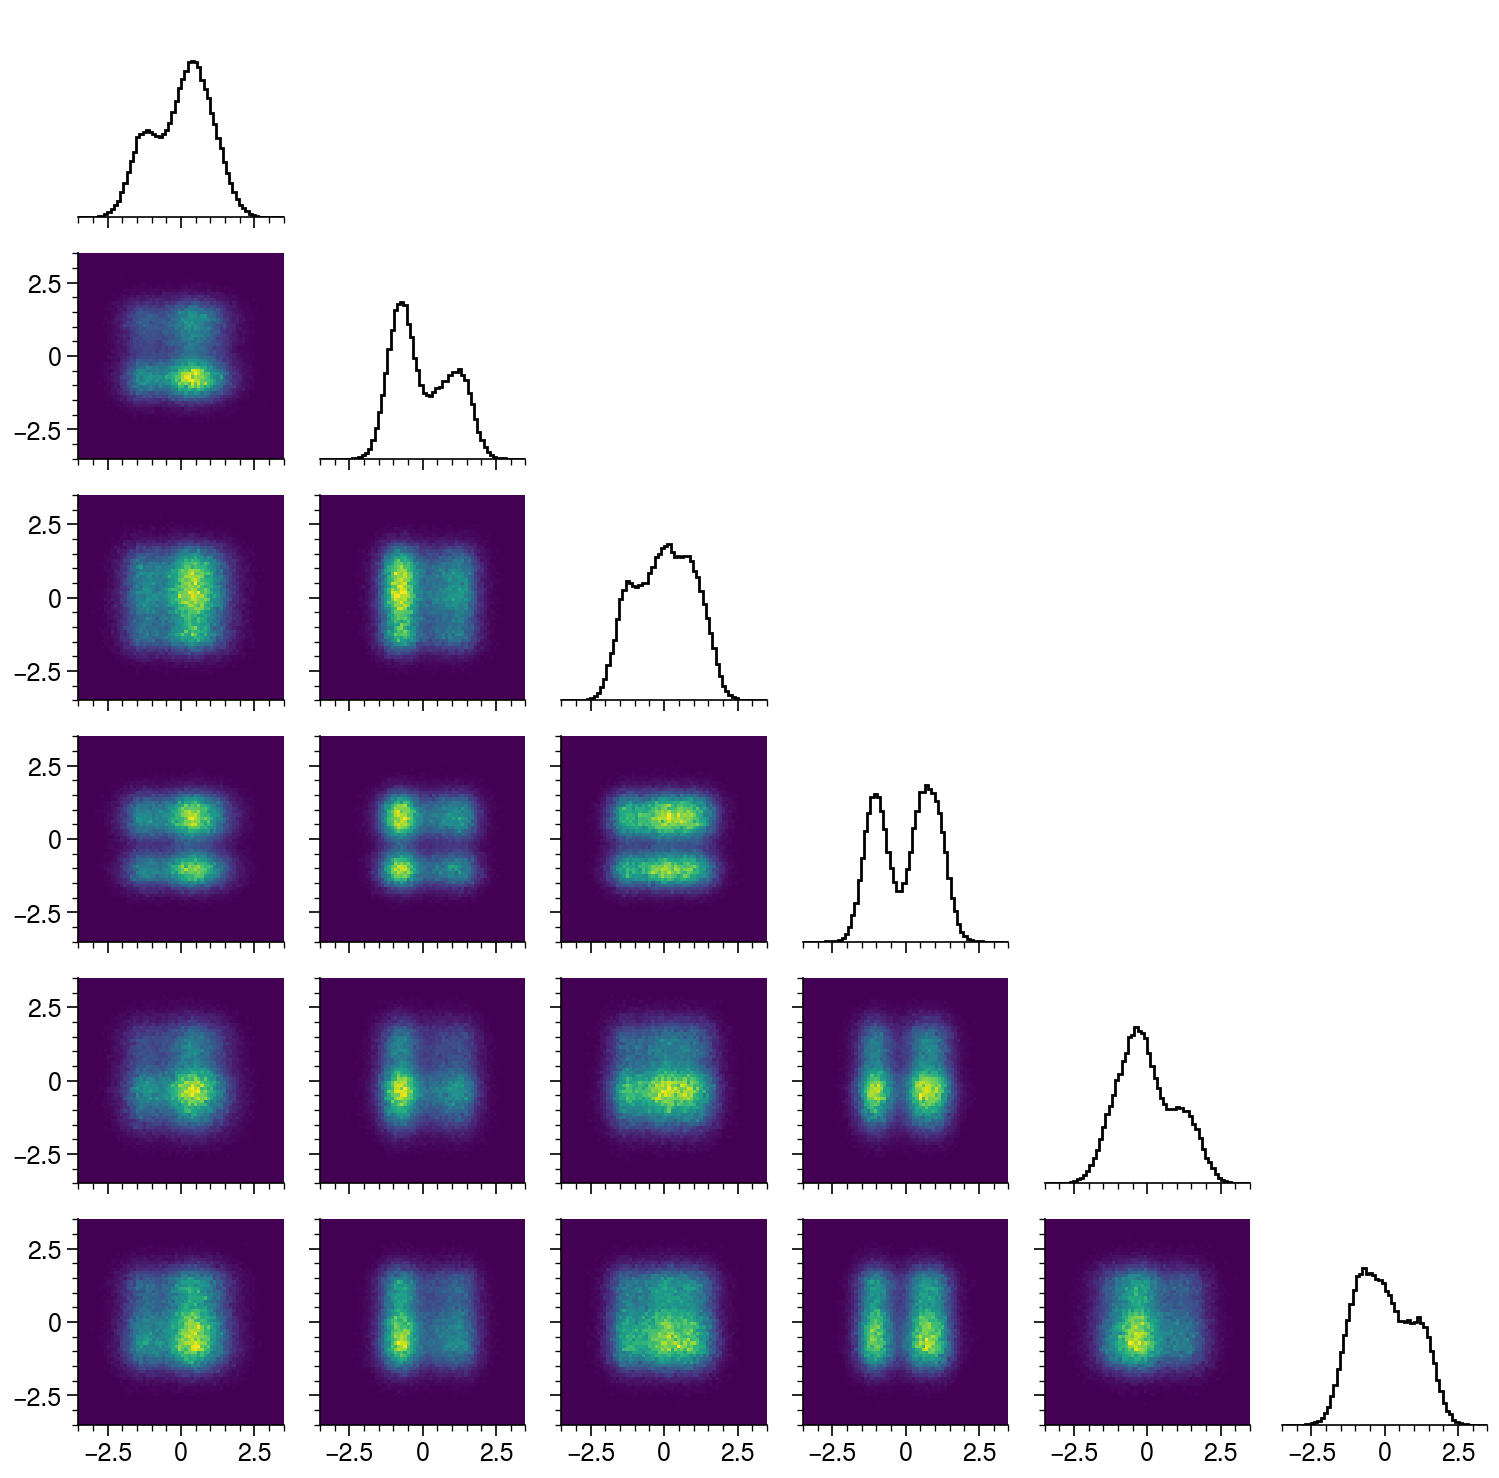

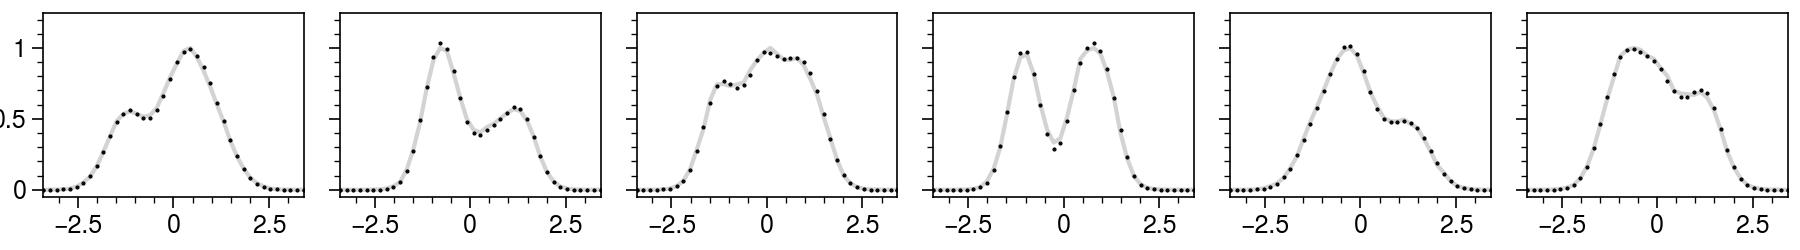

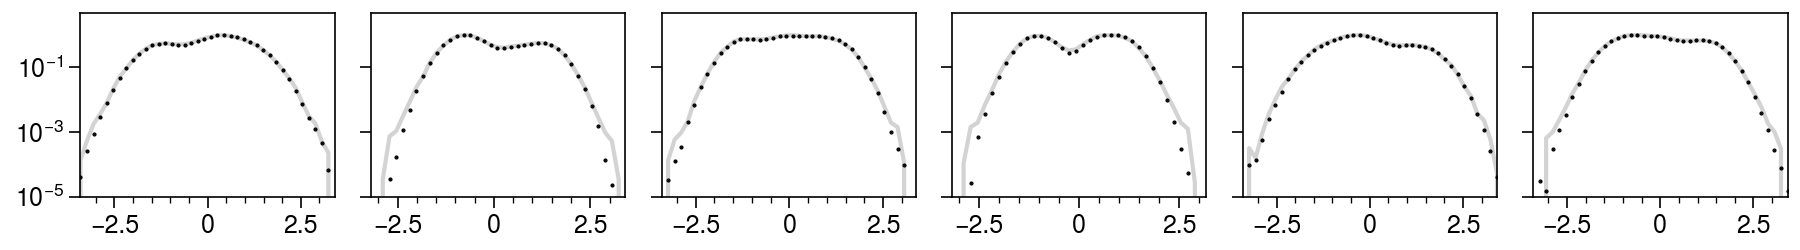

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  2%|██▎                                                                                                                                                | 226/14031 [00:00<00:06, 2257.26it/s]

  4%|██████▏                                                                                                                                            | 591/14031 [00:00<00:04, 3073.75it/s]

  7%|██████████                                                                                                                                         | 955/14031 [00:00<00:03, 3331.20it/s]

  9%|█████████████▊                                                                                                                                    | 1324/14031 [00:00<00:03, 3471.17it/s]

 12%|█████████████████▌                                                                                                                                | 1690/14031 [00:00<00:03, 3538.07it/s]

 15%|█████████████████████▍                                                                                                                            | 2059/14031 [00:00<00:03, 3588.27it/s]

 17%|█████████████████████████▎                                                                                                                        | 2430/14031 [00:00<00:03, 3627.53it/s]

 20%|█████████████████████████████                                                                                                                     | 2797/14031 [00:00<00:03, 3640.33it/s]

 23%|████████████████████████████████▉                                                                                                                 | 3164/14031 [00:00<00:02, 3648.09it/s]

 25%|████████████████████████████████████▊                                                                                                             | 3533/14031 [00:01<00:02, 3659.18it/s]

 28%|████████████████████████████████████████▌                                                                                                         | 3899/14031 [00:01<00:02, 3643.59it/s]

 30%|████████████████████████████████████████████▍                                                                                                     | 4266/14031 [00:01<00:02, 3650.33it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 4634/14031 [00:01<00:02, 3657.08it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 5003/14031 [00:01<00:02, 3666.72it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                          | 5374/14031 [00:01<00:02, 3677.01it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                      | 5742/14031 [00:01<00:02, 3674.62it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                  | 6110/14031 [00:01<00:02, 3661.78it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 6482/14031 [00:01<00:02, 3677.31it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 6851/14031 [00:01<00:01, 3681.00it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 7221/14031 [00:02<00:01, 3683.76it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 7591/14031 [00:02<00:01, 3686.26it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                               | 7963/14031 [00:02<00:01, 3695.67it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 8334/14031 [00:02<00:01, 3699.53it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 8704/14031 [00:02<00:01, 3697.85it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 9077/14031 [00:02<00:01, 3706.81it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 9448/14031 [00:02<00:01, 3707.05it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 9823/14031 [00:02<00:01, 3717.35it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 10196/14031 [00:02<00:01, 3720.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 10571/14031 [00:02<00:00, 3726.52it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 10944/14031 [00:03<00:00, 3716.64it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 11316/14031 [00:03<00:00, 3707.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 11687/14031 [00:03<00:00, 3697.90it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 12057/14031 [00:03<00:00, 3689.64it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 12430/14031 [00:03<00:00, 3699.26it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 12800/14031 [00:03<00:00, 3698.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 13171/14031 [00:03<00:00, 3699.70it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 13541/14031 [00:03<00:00, 3691.47it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 13911/14031 [00:03<00:00, 3682.81it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3648.83it/s]

{'mean_abs_error': np.float64(0.0030030028859564135)}
epoch = 3
transform=0
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 366/12015 [00:00<00:03, 3652.80it/s]

  6%|████████▉                                                                                                                                          | 732/12015 [00:00<00:03, 3645.08it/s]

  9%|█████████████▎                                                                                                                                    | 1097/12015 [00:00<00:03, 3617.11it/s]

 12%|█████████████████▋                                                                                                                                | 1459/12015 [00:00<00:02, 3608.65it/s]

 15%|██████████████████████▏                                                                                                                           | 1821/12015 [00:00<00:02, 3611.76it/s]

 18%|██████████████████████████▌                                                                                                                       | 2185/12015 [00:00<00:02, 3619.84it/s]

 21%|██████████████████████████████▉                                                                                                                   | 2547/12015 [00:00<00:02, 3613.95it/s]

 24%|███████████████████████████████████▍                                                                                                              | 2912/12015 [00:00<00:02, 3624.51it/s]

 27%|███████████████████████████████████████▊                                                                                                          | 3279/12015 [00:00<00:02, 3635.66it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 3649/12015 [00:01<00:02, 3653.69it/s]

 33%|████████████████████████████████████████████████▊                                                                                                 | 4015/12015 [00:01<00:02, 3647.60it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                            | 4380/12015 [00:01<00:02, 3633.71it/s]

 39%|█████████████████████████████████████████████████████████▋                                                                                        | 4744/12015 [00:01<00:02, 3626.96it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                    | 5108/12015 [00:01<00:01, 3630.22it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                               | 5478/12015 [00:01<00:01, 3650.15it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                           | 5846/12015 [00:01<00:01, 3657.40it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                      | 6217/12015 [00:01<00:01, 3672.56it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 6589/12015 [00:01<00:01, 3684.98it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 6958/12015 [00:01<00:01, 3672.69it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 7327/12015 [00:02<00:01, 3677.19it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 7695/12015 [00:02<00:01, 3677.03it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 8064/12015 [00:02<00:01, 3678.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 8432/12015 [00:02<00:00, 3672.01it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 8800/12015 [00:02<00:00, 3628.13it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 9163/12015 [00:02<00:00, 3581.28it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 9522/12015 [00:02<00:00, 3548.00it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 9885/12015 [00:02<00:00, 3570.66it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 10254/12015 [00:02<00:00, 3605.43it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 10622/12015 [00:02<00:00, 3625.30it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 10986/12015 [00:03<00:00, 3628.61it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11349/12015 [00:03<00:00, 3532.35it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 11712/12015 [00:03<00:00, 3560.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3622.86it/s]

transform=1
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 362/12015 [00:00<00:03, 3618.74it/s]

  6%|████████▉                                                                                                                                          | 728/12015 [00:00<00:03, 3640.97it/s]

  9%|█████████████▎                                                                                                                                    | 1094/12015 [00:00<00:02, 3648.26it/s]

 12%|█████████████████▊                                                                                                                                | 1461/12015 [00:00<00:02, 3655.02it/s]

 15%|██████████████████████▏                                                                                                                           | 1828/12015 [00:00<00:02, 3657.04it/s]

 18%|██████████████████████████▋                                                                                                                       | 2196/12015 [00:00<00:02, 3662.51it/s]

 21%|███████████████████████████████▏                                                                                                                  | 2569/12015 [00:00<00:02, 3681.50it/s]

 24%|███████████████████████████████████▋                                                                                                              | 2939/12015 [00:00<00:02, 3684.64it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 3308/12015 [00:00<00:02, 3686.00it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 3677/12015 [00:01<00:02, 3685.07it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4046/12015 [00:01<00:02, 3679.16it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 4415/12015 [00:01<00:02, 3681.90it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                       | 4786/12015 [00:01<00:01, 3690.04it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 5158/12015 [00:01<00:01, 3697.97it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                              | 5530/12015 [00:01<00:01, 3703.08it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 5901/12015 [00:01<00:01, 3702.42it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 6272/12015 [00:01<00:01, 3694.33it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                 | 6642/12015 [00:01<00:01, 3690.39it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 7012/12015 [00:01<00:01, 3684.91it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 7384/12015 [00:02<00:01, 3694.66it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 7754/12015 [00:02<00:01, 3692.02it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 8124/12015 [00:02<00:01, 3684.09it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 8493/12015 [00:02<00:00, 3681.94it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 8865/12015 [00:02<00:00, 3691.58it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 9236/12015 [00:02<00:00, 3696.32it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 9607/12015 [00:02<00:00, 3699.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 9979/12015 [00:02<00:00, 3705.23it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 10351/12015 [00:02<00:00, 3707.44it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 10724/12015 [00:02<00:00, 3713.82it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 11098/12015 [00:03<00:00, 3719.45it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11470/12015 [00:03<00:00, 3718.49it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 11842/12015 [00:03<00:00, 3716.61it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3691.60it/s]

transform=2
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▌                                                                                                                                              | 371/12015 [00:00<00:03, 3702.45it/s]

  6%|█████████                                                                                                                                          | 745/12015 [00:00<00:03, 3721.28it/s]

  9%|█████████████▌                                                                                                                                    | 1118/12015 [00:00<00:02, 3713.22it/s]

 12%|██████████████████                                                                                                                                | 1490/12015 [00:00<00:02, 3707.68it/s]

 15%|██████████████████████▌                                                                                                                           | 1861/12015 [00:00<00:02, 3700.09it/s]

 19%|███████████████████████████                                                                                                                       | 2232/12015 [00:00<00:02, 3684.76it/s]

 22%|███████████████████████████████▌                                                                                                                  | 2601/12015 [00:00<00:02, 3675.51it/s]

 25%|████████████████████████████████████                                                                                                              | 2969/12015 [00:00<00:02, 3669.17it/s]

 28%|████████████████████████████████████████▌                                                                                                         | 3338/12015 [00:00<00:02, 3674.67it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 3707/12015 [00:01<00:02, 3678.07it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 4078/12015 [00:01<00:02, 3685.80it/s]

 37%|██████████████████████████████████████████████████████                                                                                            | 4452/12015 [00:01<00:02, 3700.61it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                       | 4824/12015 [00:01<00:01, 3705.37it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 5195/12015 [00:01<00:01, 3702.47it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 5566/12015 [00:01<00:01, 3700.89it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 5938/12015 [00:01<00:01, 3704.55it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 6312/12015 [00:01<00:01, 3713.32it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 6685/12015 [00:01<00:01, 3716.63it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7057/12015 [00:01<00:01, 3713.46it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7430/12015 [00:02<00:01, 3716.84it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7802/12015 [00:02<00:01, 3713.00it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 8174/12015 [00:02<00:01, 3711.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 8547/12015 [00:02<00:00, 3716.00it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 8919/12015 [00:02<00:00, 3712.70it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 9291/12015 [00:02<00:00, 3712.54it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 9663/12015 [00:02<00:00, 3711.43it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 10035/12015 [00:02<00:00, 3710.95it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 10407/12015 [00:02<00:00, 3701.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 10778/12015 [00:02<00:00, 3699.82it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 11148/12015 [00:03<00:00, 3696.37it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 11518/12015 [00:03<00:00, 3690.92it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11890/12015 [00:03<00:00, 3696.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3700.83it/s]

transform=3
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 366/12015 [00:00<00:03, 3659.23it/s]

  6%|█████████                                                                                                                                          | 736/12015 [00:00<00:03, 3681.86it/s]

  9%|█████████████▍                                                                                                                                    | 1108/12015 [00:00<00:02, 3695.06it/s]

 12%|█████████████████▉                                                                                                                                | 1479/12015 [00:00<00:02, 3699.87it/s]

 15%|██████████████████████▌                                                                                                                           | 1853/12015 [00:00<00:02, 3712.31it/s]

 19%|███████████████████████████                                                                                                                       | 2225/12015 [00:00<00:02, 3713.13it/s]

 22%|███████████████████████████████▌                                                                                                                  | 2597/12015 [00:00<00:02, 3707.46it/s]

 25%|████████████████████████████████████                                                                                                              | 2968/12015 [00:00<00:02, 3707.22it/s]

 28%|████████████████████████████████████████▌                                                                                                         | 3342/12015 [00:00<00:02, 3716.50it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 3715/12015 [00:01<00:02, 3718.56it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 4088/12015 [00:01<00:02, 3721.70it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                           | 4461/12015 [00:01<00:02, 3710.59it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                       | 4833/12015 [00:01<00:01, 3710.06it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                  | 5205/12015 [00:01<00:01, 3712.18it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 5577/12015 [00:01<00:01, 3712.06it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                         | 5949/12015 [00:01<00:01, 3708.00it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 6320/12015 [00:01<00:01, 3707.10it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                                | 6691/12015 [00:01<00:01, 3702.65it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 7062/12015 [00:01<00:01, 3647.63it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 7429/12015 [00:02<00:01, 3652.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 7799/12015 [00:02<00:01, 3664.51it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 8166/12015 [00:02<00:01, 3665.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 8536/12015 [00:02<00:00, 3674.31it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8907/12015 [00:02<00:00, 3684.08it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 9280/12015 [00:02<00:00, 3695.64it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 9650/12015 [00:02<00:00, 3696.48it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 10022/12015 [00:02<00:00, 3701.46it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 10395/12015 [00:02<00:00, 3707.34it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 10768/12015 [00:02<00:00, 3712.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 11141/12015 [00:03<00:00, 3715.82it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 11513/12015 [00:03<00:00, 3702.84it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11884/12015 [00:03<00:00, 3700.90it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3697.75it/s]

transform=4
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                              | 360/12015 [00:00<00:03, 3592.71it/s]

  6%|████████▊                                                                                                                                          | 720/12015 [00:00<00:03, 3562.32it/s]

  9%|█████████████▏                                                                                                                                    | 1083/12015 [00:00<00:03, 3590.78it/s]

 12%|█████████████████▌                                                                                                                                | 1449/12015 [00:00<00:02, 3615.30it/s]

 15%|██████████████████████                                                                                                                            | 1812/12015 [00:00<00:02, 3618.96it/s]

 18%|██████████████████████████▍                                                                                                                       | 2179/12015 [00:00<00:02, 3634.17it/s]

 21%|██████████████████████████████▉                                                                                                                   | 2543/12015 [00:00<00:02, 3625.54it/s]

 24%|███████████████████████████████████▎                                                                                                              | 2906/12015 [00:00<00:02, 3604.65it/s]

 27%|███████████████████████████████████████▋                                                                                                          | 3267/12015 [00:00<00:02, 3559.33it/s]

 30%|████████████████████████████████████████████                                                                                                      | 3626/12015 [00:01<00:02, 3566.65it/s]

 33%|████████████████████████████████████████████████▍                                                                                                 | 3983/12015 [00:01<00:02, 3559.77it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 4354/12015 [00:01<00:02, 3603.35it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 4715/12015 [00:01<00:02, 3578.48it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                    | 5073/12015 [00:01<00:01, 3568.37it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5441/12015 [00:01<00:01, 3600.36it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5802/12015 [00:01<00:01, 3598.26it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                       | 6168/12015 [00:01<00:01, 3614.00it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 6534/12015 [00:01<00:01, 3625.30it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 6897/12015 [00:01<00:01, 3483.68it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 7247/12015 [00:02<00:01, 3407.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 7589/12015 [00:02<00:01, 3403.32it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 7931/12015 [00:02<00:01, 3330.56it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 8267/12015 [00:02<00:01, 3338.84it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 8602/12015 [00:02<00:01, 3268.43it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 8930/12015 [00:02<00:00, 3246.91it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 9276/12015 [00:02<00:00, 3307.50it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 9626/12015 [00:02<00:00, 3363.06it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 9963/12015 [00:02<00:00, 3324.24it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 10296/12015 [00:02<00:00, 3304.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 10640/12015 [00:03<00:00, 3342.33it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 10992/12015 [00:03<00:00, 3394.09it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11347/12015 [00:03<00:00, 3437.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 11708/12015 [00:03<00:00, 3486.47it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3484.08it/s]

transform=5
diagnostic=0


  0%|                                                                                                                                                               | 0/12015 [00:00<?, ?it/s]

  3%|████▎                                                                                                                                              | 355/12015 [00:00<00:03, 3542.39it/s]

  6%|████████▋                                                                                                                                          | 710/12015 [00:00<00:03, 3536.01it/s]

  9%|████████████▉                                                                                                                                     | 1067/12015 [00:00<00:03, 3548.94it/s]

 12%|█████████████████▎                                                                                                                                | 1429/12015 [00:00<00:02, 3576.73it/s]

 15%|█████████████████████▊                                                                                                                            | 1797/12015 [00:00<00:02, 3612.33it/s]

 18%|██████████████████████████▎                                                                                                                       | 2165/12015 [00:00<00:02, 3633.02it/s]

 21%|██████████████████████████████▋                                                                                                                   | 2529/12015 [00:00<00:02, 3630.53it/s]

 24%|███████████████████████████████████▏                                                                                                              | 2893/12015 [00:00<00:02, 3591.20it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 3253/12015 [00:00<00:02, 3588.01it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 3612/12015 [00:01<00:02, 3582.11it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 3973/12015 [00:01<00:02, 3587.69it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 4339/12015 [00:01<00:02, 3608.21it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 4708/12015 [00:01<00:02, 3632.36it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                    | 5073/12015 [00:01<00:01, 3636.32it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 5438/12015 [00:01<00:01, 3639.91it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 5803/12015 [00:01<00:01, 3633.85it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                       | 6170/12015 [00:01<00:01, 3644.25it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 6535/12015 [00:01<00:01, 3645.24it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                              | 6902/12015 [00:01<00:01, 3651.29it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 7273/12015 [00:02<00:01, 3666.20it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7646/12015 [00:02<00:01, 3684.23it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 8020/12015 [00:02<00:01, 3700.18it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 8391/12015 [00:02<00:00, 3695.34it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 8761/12015 [00:02<00:00, 3660.55it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 9128/12015 [00:02<00:00, 3644.33it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 9493/12015 [00:02<00:00, 3643.36it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 9858/12015 [00:02<00:00, 3631.21it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 10222/12015 [00:02<00:00, 3617.97it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 10585/12015 [00:02<00:00, 3620.48it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 10949/12015 [00:03<00:00, 3626.13it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11320/12015 [00:03<00:00, 3648.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 11692/12015 [00:03<00:00, 3668.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:03<00:00, 3634.86it/s]

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▊                                                                                                                                               | 366/14031 [00:00<00:03, 3650.21it/s]

  5%|███████▋                                                                                                                                           | 732/14031 [00:00<00:03, 3633.74it/s]

  8%|███████████▍                                                                                                                                      | 1096/14031 [00:00<00:03, 3631.60it/s]

 10%|███████████████▏                                                                                                                                  | 1462/14031 [00:00<00:03, 3640.03it/s]

 13%|███████████████████                                                                                                                               | 1829/14031 [00:00<00:03, 3647.75it/s]

 16%|██████████████████████▊                                                                                                                           | 2198/14031 [00:00<00:03, 3661.35it/s]

 18%|██████████████████████████▋                                                                                                                       | 2567/14031 [00:00<00:03, 3669.51it/s]

 21%|██████████████████████████████▌                                                                                                                   | 2934/14031 [00:00<00:03, 3668.63it/s]

 24%|██████████████████████████████████▎                                                                                                               | 3302/14031 [00:00<00:02, 3669.72it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 3671/14031 [00:01<00:02, 3673.34it/s]

 29%|██████████████████████████████████████████                                                                                                        | 4039/14031 [00:01<00:02, 3670.43it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 4407/14031 [00:01<00:02, 3666.73it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 4775/14031 [00:01<00:02, 3670.55it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 5143/14031 [00:01<00:02, 3672.44it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 5513/14031 [00:01<00:02, 3680.32it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 5884/14031 [00:01<00:02, 3688.69it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                 | 6255/14031 [00:01<00:02, 3693.37it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 6628/14031 [00:01<00:01, 3704.28it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 7002/14031 [00:01<00:01, 3712.03it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 7375/14031 [00:02<00:01, 3714.81it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▌                                                                 | 7748/14031 [00:02<00:01, 3718.44it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 8122/14031 [00:02<00:01, 3722.80it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 8495/14031 [00:02<00:01, 3720.30it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 8868/14031 [00:02<00:01, 3717.19it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 9240/14031 [00:02<00:01, 3714.36it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 9613/14031 [00:02<00:01, 3716.33it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 9985/14031 [00:02<00:01, 3714.05it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 10358/14031 [00:02<00:00, 3718.70it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 10732/14031 [00:02<00:00, 3723.46it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 11105/14031 [00:03<00:00, 3715.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 11478/14031 [00:03<00:00, 3718.65it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 11850/14031 [00:03<00:00, 3705.36it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 12221/14031 [00:03<00:00, 3680.72it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 12590/14031 [00:03<00:00, 3680.29it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 12959/14031 [00:03<00:00, 3683.03it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 13328/14031 [00:03<00:00, 3674.25it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 13696/14031 [00:03<00:00, 3669.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3684.32it/s]

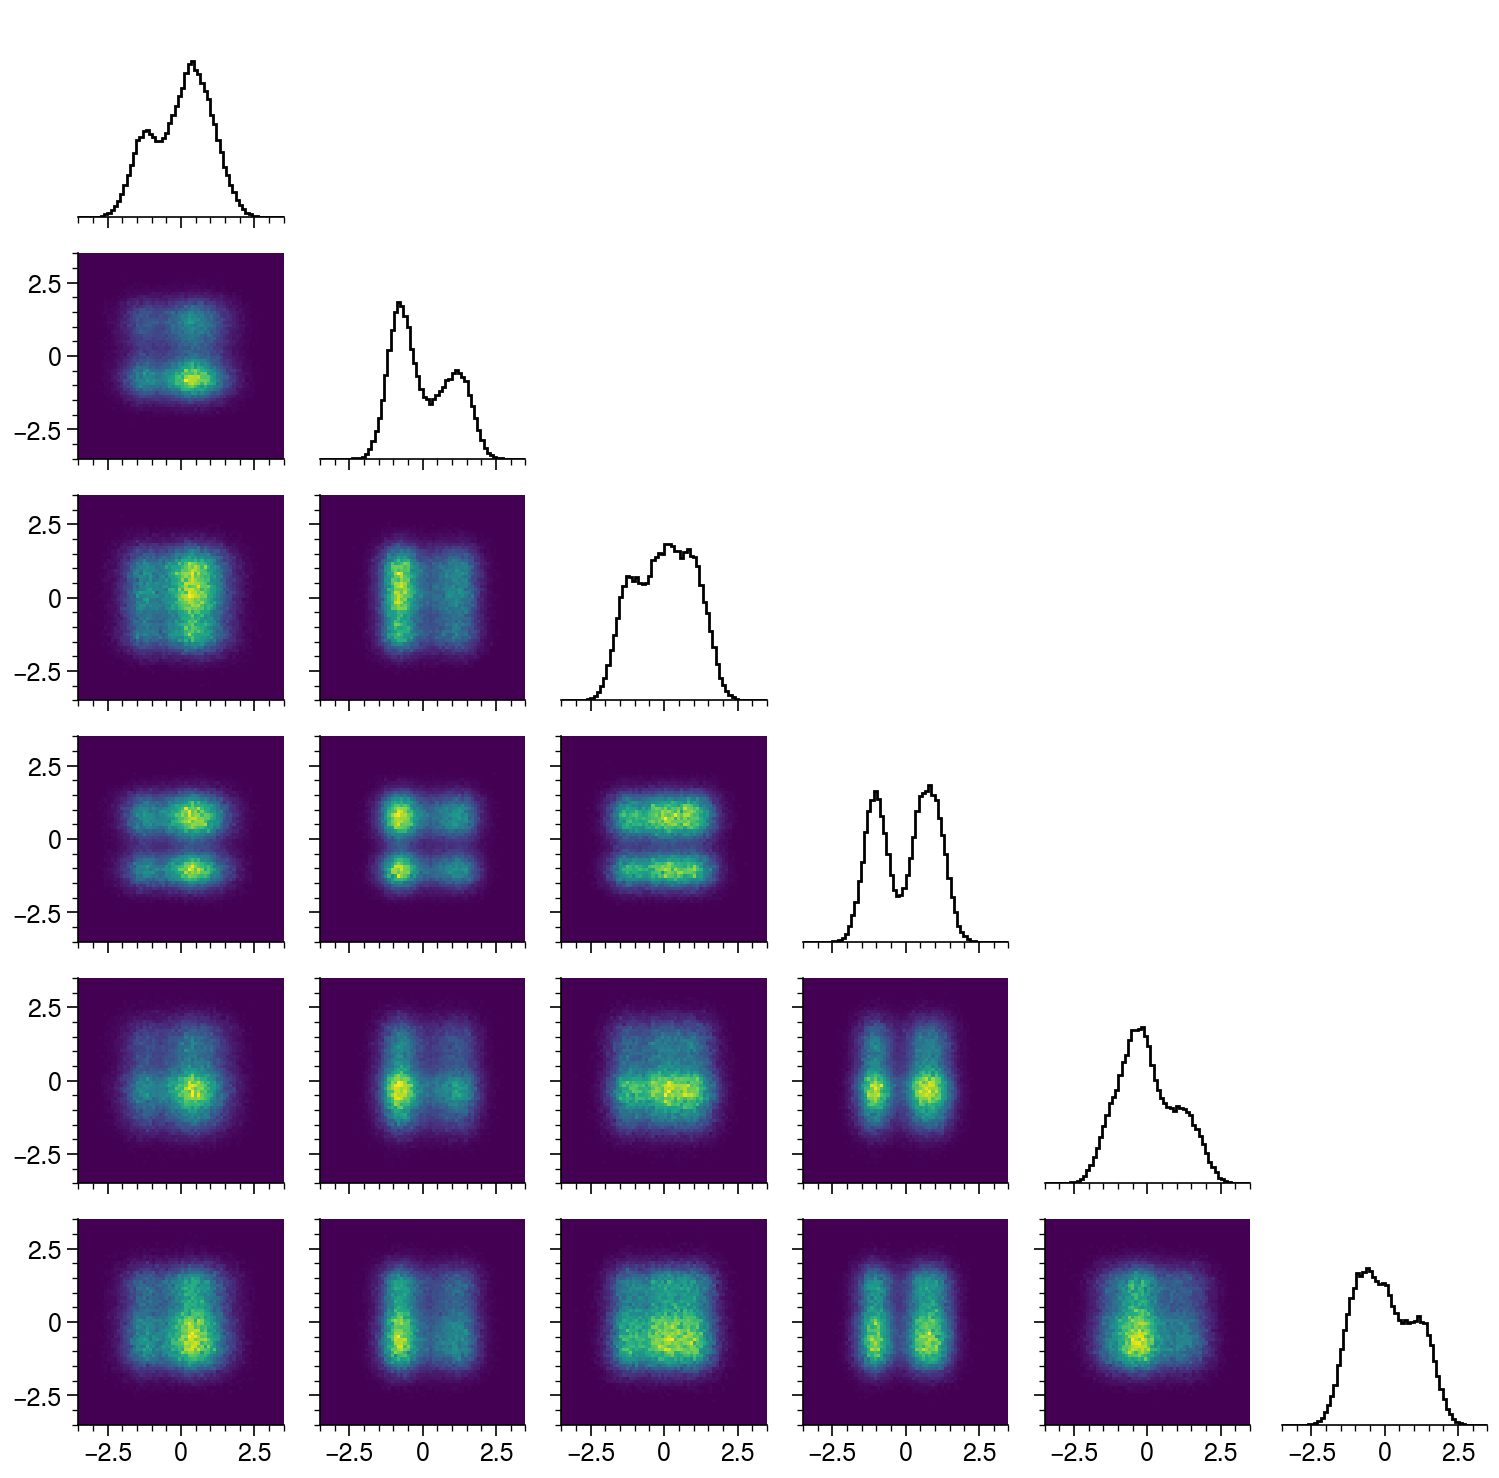

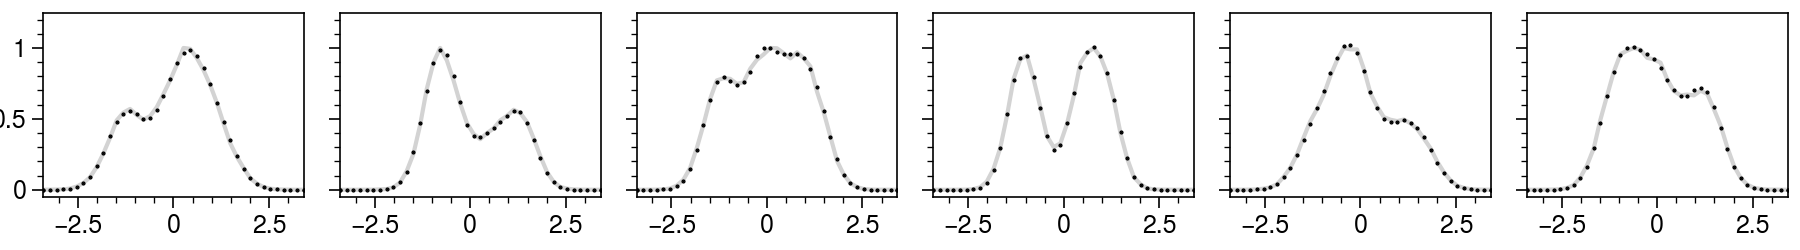

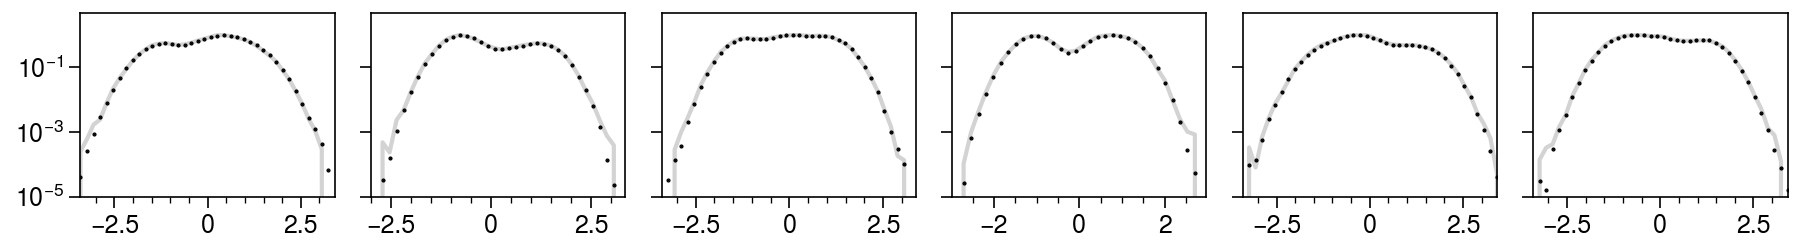

  0%|                                                                                                                                                               | 0/14031 [00:00<?, ?it/s]

  3%|███▋                                                                                                                                               | 356/14031 [00:00<00:03, 3552.82it/s]

  5%|███████▍                                                                                                                                           | 714/14031 [00:00<00:03, 3564.19it/s]

  8%|███████████▏                                                                                                                                      | 1071/14031 [00:00<00:03, 3553.53it/s]

 10%|██████████████▉                                                                                                                                   | 1434/14031 [00:00<00:03, 3582.04it/s]

 13%|██████████████████▊                                                                                                                               | 1805/14031 [00:00<00:03, 3627.27it/s]

 15%|██████████████████████▌                                                                                                                           | 2174/14031 [00:00<00:03, 3646.07it/s]

 18%|██████████████████████████▍                                                                                                                       | 2539/14031 [00:00<00:03, 3634.83it/s]

 21%|██████████████████████████████▏                                                                                                                   | 2903/14031 [00:00<00:03, 3636.03it/s]

 23%|██████████████████████████████████                                                                                                                | 3271/14031 [00:00<00:02, 3648.57it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 3637/14031 [00:01<00:02, 3650.90it/s]

 29%|█████████████████████████████████████████▋                                                                                                        | 4003/14031 [00:01<00:02, 3641.20it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 4368/14031 [00:01<00:02, 3631.88it/s]

 34%|█████████████████████████████████████████████████▏                                                                                                | 4732/14031 [00:01<00:02, 3612.32it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 5095/14031 [00:01<00:02, 3616.91it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 5464/14031 [00:01<00:02, 3638.15it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                     | 5837/14031 [00:01<00:02, 3664.45it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 6205/14031 [00:01<00:02, 3666.99it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 6572/14031 [00:01<00:02, 3654.01it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 6938/14031 [00:01<00:01, 3638.46it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 7307/14031 [00:02<00:01, 3651.16it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 7676/14031 [00:02<00:01, 3660.46it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                              | 8043/14031 [00:02<00:01, 3653.42it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 8409/14031 [00:02<00:01, 3651.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 8776/14031 [00:02<00:01, 3655.02it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 9142/14031 [00:02<00:01, 3652.58it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 9513/14031 [00:02<00:01, 3667.31it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 9882/14031 [00:02<00:01, 3671.89it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 10250/14031 [00:02<00:01, 3667.54it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 10617/14031 [00:02<00:00, 3661.67it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 10984/14031 [00:03<00:00, 3656.34it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 11352/14031 [00:03<00:00, 3660.86it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 11719/14031 [00:03<00:00, 3652.26it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 12085/14031 [00:03<00:00, 3649.07it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 12454/14031 [00:03<00:00, 3660.74it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 12826/14031 [00:03<00:00, 3677.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 13197/14031 [00:03<00:00, 3685.24it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 13566/14031 [00:03<00:00, 3675.90it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 13934/14031 [00:03<00:00, 3662.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:03<00:00, 3647.52it/s]

{'mean_abs_error': np.float64(0.002535969542311755)}


In [11]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=eval_model,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)